In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import os
plt.rcParams["figure.figsize"]=14,5
import holidays
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings("ignore")
import sys
import datetime


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate
import requests
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
# logger.info(f"tf version:{tf.__version__}")
# from tensorflow import keras
from tensorflow.keras.regularizers import l2                # type: ignore
from tensorflow.keras.optimizers import Adam                # type: ignore
# from tensorflow.keras import Sequential                   # type: ignore
# from tensorflow.keras.layers import LSTM, Dropout, Dense  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping        # type: ignore
from tensorflow.keras import layers                         # type: ignore
from tensorflow.keras.models import Sequential              # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout    # type: ignore
from tensorflow.keras import regularizers                   # type: ignore
# from sklearn.inspection import permutation_importance
from tensorflow.keras.models import load_model              # type: ignore

np.set_printoptions(precision=3, suppress=True)
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from math import sqrt


In [2]:
def initial_data_ingestion():
    df_complete_data = pd.read_parquet('HT_meter_complete_data_9_id.parquet')
    df = df_complete_data[df_complete_data['sensor']=="6148740eea9db0.29702291"]  ## Jamia HT METER
    df = df.copy()

    df.drop("sensor", axis=1, inplace=True)
    print(f"df rows: {len(df)}")
    print(f"Duplicated rows: {df.duplicated().sum()}")
    df.set_index("creation_time", drop=True, inplace=True)
    df = df.loc[df.index.year>2022]
    df = df.loc[~ ((df.index.year==2024) & (df.index.month>5))]

    print(f"Duplicated rows after datetime index: {df.duplicated().sum()}")
    df = df.drop_duplicates()
    df = df[df['R_Voltage'] != 0]
    # df = df.loc[~df['R_Voltage'] == 0]
    print(f"Duplicated index: {df.index.duplicated().sum()}")
    print(f"null_values : {df.isna().sum().sum()}")
    print(f"df rows after basic checks: {len(df)}")
    return df

def initial_validation(df):
    resample_df = df[['KWh']].resample(rule="30min").asfreq()
    print(f"null vlaues after resampling: {resample_df.isna().sum().sum()}")
    # resample_df[resample_df.isna().any(axis=1)]
    resample_df = resample_df.interpolate(method="linear")
    print(f"null values after filling: {resample_df.isna().sum().sum()}")
    resample_df['KWh'] = resample_df['KWh'].rolling(window=4).mean()
    resample_df['KWh'].plot()
    plt.show()
    return resample_df

def data_ingestion_training(month):
    df_complete_data = pd.read_parquet('HT_meter_complete_data_9_id.parquet')
    df = df_complete_data[df_complete_data['sensor']=="6148740eea9db0.29702291"]  ## Jamia HT METER
    df = df.copy()

    df.drop("sensor", axis=1, inplace=True)
    print(f"df rows: {len(df)}")
    print(f"Duplicated rows: {df.duplicated().sum()}")
    df.set_index("creation_time", drop=True, inplace=True)
    df = df.loc[df.index.year>2022]
    df = df.loc[((df.index.year==2024) & ((df.index.month>=(month-2)) & (df.index.month<(month+1))))]

    print(f"Duplicated rows after datetime index: {df.duplicated().sum()}")
    df = df.drop_duplicates()
    df = df[df['R_Voltage'] != 0]
    # df = df.loc[~df['R_Voltage'] == 0]
    print(f"Duplicated index: {df.index.duplicated().sum()}")
    print(f"null_values : {df.isna().sum().sum()}")
    print(f"df rows after basic checks: {len(df)}")
    return df

def pre_process(data):
    main_df = data[['KWh']].resample(rule="30min").asfreq()
    print(f"null vlaues after resampling: {main_df.isna().sum().sum()}")
    # resample_df[resample_df.isna().any(axis=1)]
    main_df = main_df.interpolate(method="linear")
    print(f"null values after filling: {main_df.isna().sum().sum()}")
    # resample_df['KWh'] = resample_df['KWh'].rolling(window=4).mean()
    main_df['KWh'].plot()
    # plt.show()
    return main_df

def holidays_list(start_date, end_date):
    holiday_list = []
    india_holidays = holidays.CountryHoliday('India', years=start_date.year)
    # Iterate through each date from start_date to end_date
    current_date = start_date
    while current_date <= end_date:
        # Check if the current date is a holiday in India or a Sunday
        if current_date in india_holidays or current_date.weekday() == 6:
            holiday_list.append(current_date)
        current_date += timedelta(days=1)

    return holiday_list


def correlation_matrix(df):
    correlation_matrix_data = df.corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(18, 10))
    # Draw the heatmap
    sns.heatmap(correlation_matrix_data, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
    # Show the plot
    plt.show()

def add_lags(dff, target_col, large_data= False):
    # target_map = dff['consumed_unit'].to_dict()
    target_map = dff[target_col].to_dict()
    dff['rolling_4'] = dff['KWh'].rolling(window=4).mean()

    # 1 Hour, 2 Hours, 6 Hours
    dff['lag1_hour']   =  (dff.index - pd.Timedelta('1 hour')).map(target_map)
    dff['lag2_hours']  =  (dff.index - pd.Timedelta('2 hours')).map(target_map)
    dff['lag3_hours']  =  (dff.index - pd.Timedelta('3 hours')).map(target_map)
    # dff['lag6_hours']  =  (dff.index - pd.Timedelta('6 hours')).map(target_map)
    # dff['lag12_hours'] =  (dff.index - pd.Timedelta('12 hours')).map(target_map)
    dff['lag1_day']    =  (dff.index - pd.Timedelta('1 day')).map(target_map)
    # dff['lag2_days']   =  (dff.index - pd.Timedelta('2 days')).map(target_map)
    # dff['lag3_days']   =  (dff.index - pd.Timedelta('3 days')).map(target_map)
    dff['lag7_days']   =  (dff.index - pd.Timedelta('7 days')).map(target_map)

    # if large_data:
    # dff['lag_15_day'] = (dff.index - pd.Timedelta('15 days')).map(target_map)
    dff['lag_30_day'] = (dff.index - pd.Timedelta('30 days')).map(target_map)
    # dff['lag_45_day'] = (dff.index - pd.Timedelta('45 days')).map(target_map)
        # logger.info(f" lags added for large data")
    #     return dff
    # else:
    
    dff['daily_avg'] = dff[target_col].rolling(window=48).mean()  # 24-hour rolling mean
    dff['weekly_avg'] = dff[target_col].rolling(window=7*48).mean()  # Weekly rolling mean


    # logger.info(f"lags added")
    return dff



def create_features(hourly_data,lagre_data= False):

    hourly_data = hourly_data.copy()
    # Check if the index is in datetime format
    if not isinstance(hourly_data.index, pd.DatetimeIndex):
        hourly_data.index = pd.to_datetime(hourly_data.index)
        
    hourly_data['hour'] = hourly_data.index.hour
    hourly_data['day'] = hourly_data.index.day
    hourly_data['dayofweek'] = hourly_data.index.dayofweek
    hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    # hourly_data['dayofyear'] = hourly_data.index.dayofyear
    # hourly_data['is_weekend'] = hourly_data['dayofweek'].isin([5, 6]).astype(int)
    hourly_data['holiday'] = 0
    # if lagre_data:
    # hourly_data['month'] = hourly_data.index.month
    # hourly_data['quarter'] = hourly_data.index.quarter
    # hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    # hourly_data['year'] = hourly_data.index.year

    return hourly_data

def plot_prediction(actual, predicted,timestamp=False):
    rmse = sqrt(mean_squared_error(actual, predicted))
    print("\nModel Power Evaluation")
    # print("Mean Squared Error (MSE):", mean_squared_error(actual, predicted))
    print("Mean Absolute Error (MAE):", mean_absolute_error(actual, predicted))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("R-squared:", r2_score(actual, predicted))

    # Scatter plot
    plt.figure(figsize=(10, 6))

    # Plot actual values in red
    if timestamp:
        plt.plot(actual.index, actual, color='red', label='Actual Power')
        # Plot predicted values in blue
        plt.plot(actual.index, predicted, color='blue', label='Predicted Power')    

    else:
        plt.plot(range(len(actual)), actual, color='red', label='Actual Power')
        # Plot predicted values in blue
        plt.plot(range(len(predicted)), predicted, color='blue', label='Predicted Power')
        # Adding labels and title

    plt.xlabel('Time')
    plt.ylabel('load')
    plt.title('Actual vs Predicted load')
    plt.legend()
    plt.tight_layout()
    plt.show()

def feature_engineering(dataframe, c_matrix=False):
    weather_df = pd.read_parquet("weather_data_2024_10_24.parquet")
    # latitude, longitude = "28.46072","77.537381" #"28.625361","77.376214"#, 28.628059,77.378912
    from_date = dataframe.first_valid_index().date()
    to_date = dataframe.last_valid_index().date()
    print("from_date: ",from_date,"to_date: ",to_date)

    holidays_lst= holidays_list(from_date,to_date)
    print("holidays_lst:",holidays_lst)
    df_lags = add_lags(dataframe,target_col="KWh")
    df_features = create_features(df_lags)
    for date in holidays_lst:
        df_features.loc[f"{date}", 'holiday'] = 1
    final_df = df_features.merge(weather_df,on=["creation_time"])
    final_df.dropna(inplace=True)
    if c_matrix:
        correlation_matrix(final_df)
    
    print(f"null values in final_df: {final_df.isna().sum().sum()}")
    final_df.dropna(inplace=True)
    # final_df.reset_index(drop=True, inplace=True)
    final_df.set_index("creation_time",inplace=True)
    # final_df.drop(['creation_time'],axis=1,inplace=True)
    # final_df
    return final_df

def feature_label(dataset,target_variable = "KWh"):
    # train 
    dataset_features = dataset.copy()   
    dataset_label = dataset_features.pop(target_variable)
    print(f"dataset_features shape: {dataset_features.shape}\ndataset_label shape: {dataset_label.shape}")
    return dataset_features, dataset_label

def load_scalar():
    # with open('models/Min_Max_Scaler.pkl', 'rb') as f:
    with open("models/minmax_scaler_with_rolling.pkl", 'rb') as f:
        feature_scaler = pickle.load(f)
    return feature_scaler

def save_model( model,model_type="DL", model_dir="models", model_name="lstm_model"):
    # Ensure the directory exists

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    # Save the model in TensorFlow's SavedModel format
    model_path = os.path.join(model_dir, model_name)

    if model_type =="ML":
        ML_model_path = f"{model_path}.joblib"
        joblib.dump(model, ML_model_path)
    # return model_path
    else:
        model.save(model_path)  # SavedModel format
    
    print(f"Model saved to: {model_path}")
    # return model_path


def reshape_fn(dataset):
    return np.array(dataset).reshape(((dataset.shape[0]),1,dataset.shape[1]))

def model_training(train_dataset,val_dataset,model):
    train_features,train_label = feature_label(train_dataset)
    val_features, val_label = feature_label(val_dataset)
    feature_scaler = load_scalar()
    
    if model == "ML":
        pass
    if model == "DL":
        reshaped_train_features= reshape_fn(feature_scaler.transform(train_features))
        reshaped_val_features = reshape_fn(feature_scaler.transform(val_features))
        print(reshaped_train_features.shape)
        print(reshaped_val_features.shape)
        
        # Build LSTM model with increased dropout and L2 regularization
        lstm_model = Sequential([            
            # Adding LSTM layers with increased dropout
            LSTM(units=64, return_sequences=True, input_shape=(reshaped_train_features.shape[1], reshaped_train_features.shape[2])),
            Dropout(0.3),  # Increased dropout
            LSTM(units=64, return_sequences=False),
            Dropout(0.3),  # Increased dropout
            # Adding dense output layer with L2 regularization
            Dense(units=1, kernel_regularizer=l2(0.01))  # L2 regularization
        ])
        # Compile the model
        lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error'
        )
        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

        # Train the model with early stopping
        history = lstm_model.fit(reshaped_train_features, train_label, epochs=500, batch_size=64, 
                                validation_data=(reshaped_val_features, val_label), 
                                callbacks=[early_stopping])
        return lstm_model

def prediction(dataset,model):
    feature_scaler = load_scalar()
    dataset_features,dataset_label = feature_label(dataset)
    reshaped_dataset_features = reshape_fn(feature_scaler.transform(dataset_features))
    pred = model.predict(reshaped_dataset_features)
    plot_prediction(dataset_label, pred,timestamp =True)
    return pred 

def day_wise_prediction(dataset,day):
    return dataset.loc[dataset.index.day==day]



df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 38
Duplicated index: 0
null_values : 0
df rows after basic checks: 24777
null vlaues after resampling: 39
null values after filling: 0


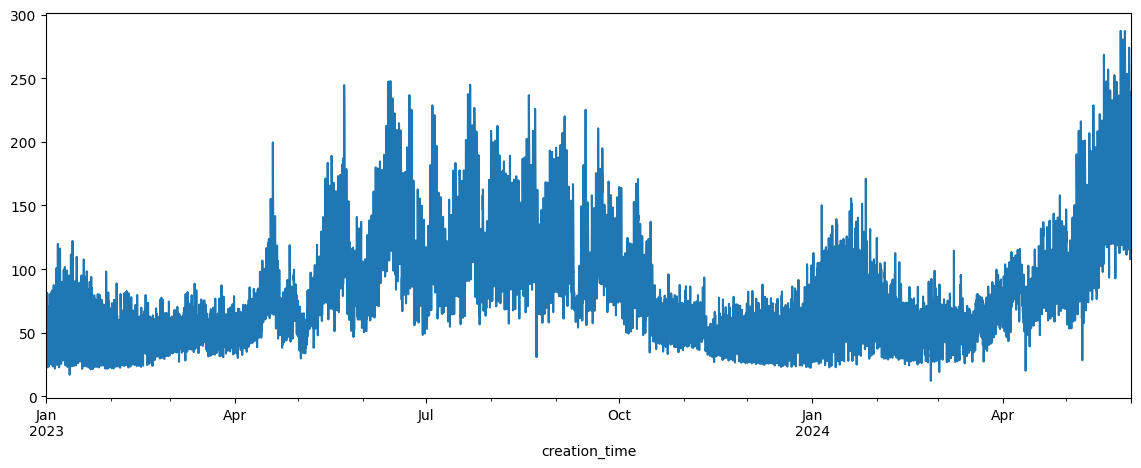

null vlaues after resampling: 3
null values after filling: 3
from_date:  2023-01-01 to_date:  2024-05-31
holidays_lst: [datetime.date(2023, 1, 1), datetime.date(2023, 1, 8), datetime.date(2023, 1, 14), datetime.date(2023, 1, 15), datetime.date(2023, 1, 22), datetime.date(2023, 1, 26), datetime.date(2023, 1, 29), datetime.date(2023, 2, 5), datetime.date(2023, 2, 12), datetime.date(2023, 2, 19), datetime.date(2023, 2, 26), datetime.date(2023, 3, 5), datetime.date(2023, 3, 8), datetime.date(2023, 3, 12), datetime.date(2023, 3, 19), datetime.date(2023, 3, 26), datetime.date(2023, 4, 2), datetime.date(2023, 4, 7), datetime.date(2023, 4, 9), datetime.date(2023, 4, 16), datetime.date(2023, 4, 21), datetime.date(2023, 4, 22), datetime.date(2023, 4, 23), datetime.date(2023, 4, 30), datetime.date(2023, 5, 1), datetime.date(2023, 5, 7), datetime.date(2023, 5, 14), datetime.date(2023, 5, 21), datetime.date(2023, 5, 28), datetime.date(2023, 6, 4), datetime.date(2023, 6, 11), datetime.date(2023, 6, 

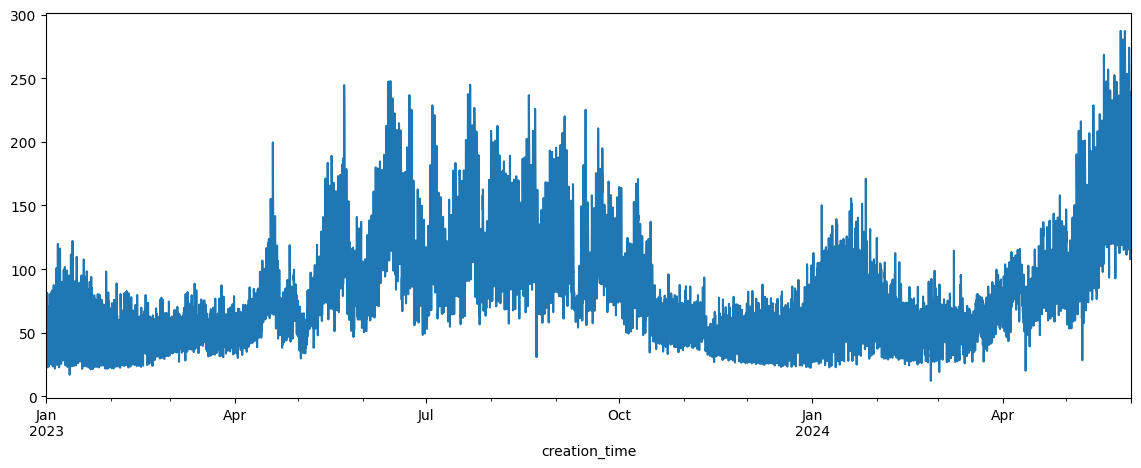

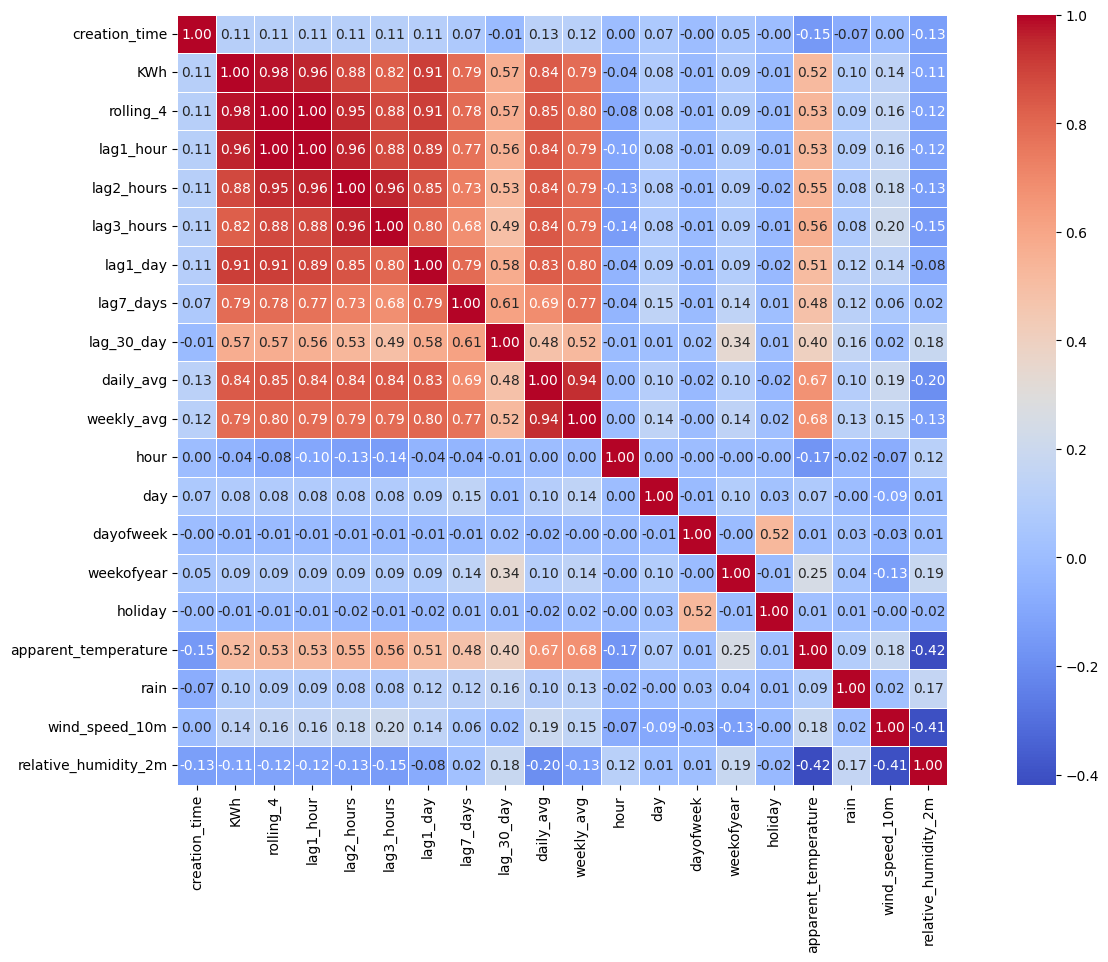

null values in final_df: 0
train_dataset_from_date:  2023-01-31 train_dataset_to_date:  2024-04-30
val_dataset_from_date:  2024-05-01 val_dataset_to_date:  2024-05-31


In [3]:
df = initial_data_ingestion()
resample_df = initial_validation(df)
final_df = feature_engineering(pre_process(resample_df),c_matrix=True)

train_dataset = final_df.loc[~((final_df.index.month==5)& (final_df.index.year == 2024))]
from_date = train_dataset.first_valid_index().date()
to_date = train_dataset.last_valid_index().date()
print("train_dataset_from_date: ",from_date,"train_dataset_to_date: ",to_date)
val_dataset = final_df.loc[(final_df.index.month==5)& (final_df.index.year == 2024)]
from_date = val_dataset.first_valid_index().date()
to_date = val_dataset.last_valid_index().date()
print("val_dataset_from_date: ",from_date,"val_dataset_to_date: ",to_date)




<Axes: xlabel='creation_time'>

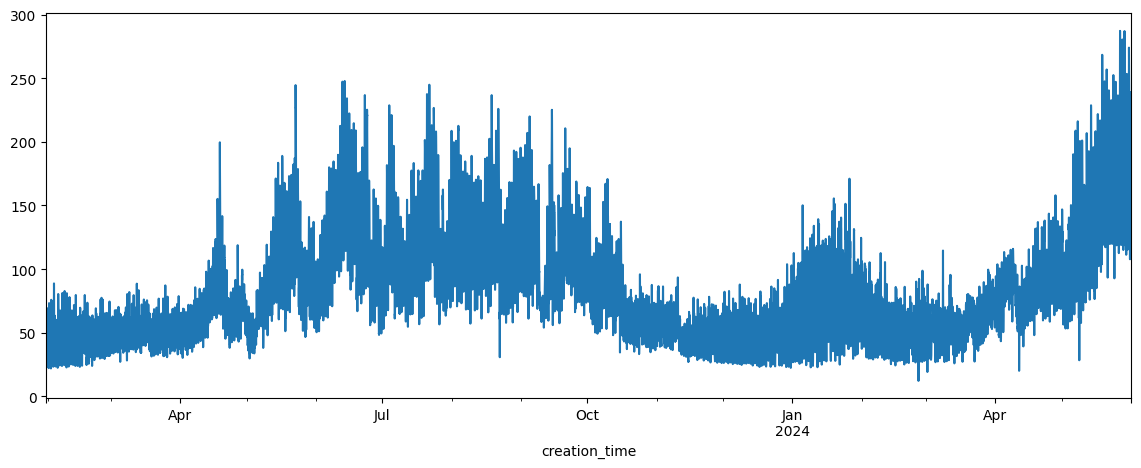

In [4]:
final_df['KWh'].plot()

load base model trained till april 2024 data

In [5]:
base_model = load_model("models/base_lstm")
feature_scaler = load_scalar()

load 5th month data (may)
and make prediction with base model

dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
47/47 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 5.876801542569228
Root Mean Squared Error (RMSE): 11.351820183131297
R-squared: 0.9490693209714686


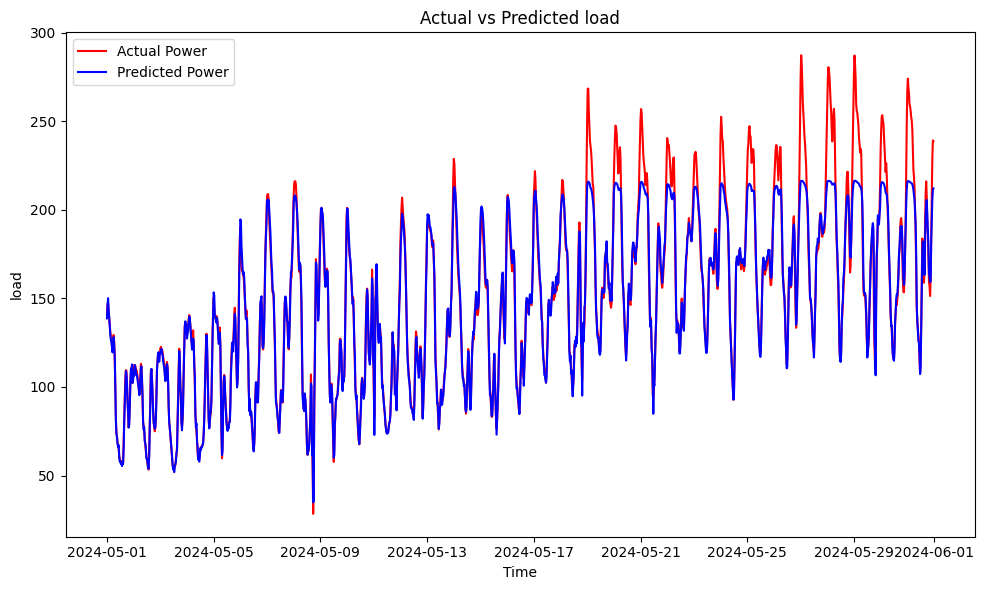

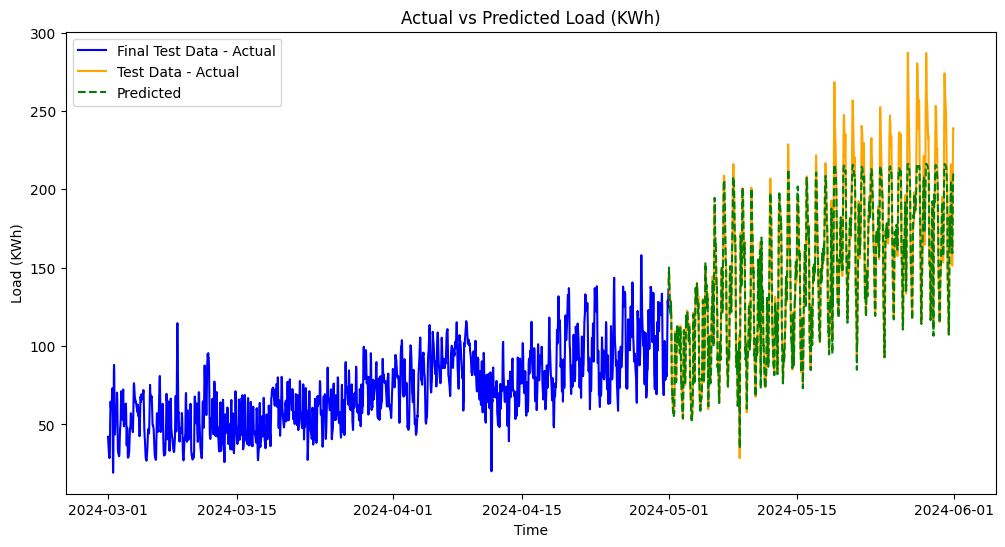

In [6]:
may_dataset = val_dataset.copy()
last_two_month_data = final_df.loc[(final_df.index.month.isin([3, 4])) & (final_df.index.year == 2024)]
# may_dataset
# may_features, may_label = feature_label(may_dataset)
# reshaped_may_features= reshape_fn(feature_scaler.transform(may_features))

predicted = prediction(may_dataset,base_model)
# Plot the actual test data from `final_test_df` and `test_dataset`
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'],label="Final Test Data - Actual", color="blue")
plt.plot(may_dataset['KWh'],label="Test Data - Actual", color="orange")
# final_test_df['KWh'].plot(label="Final Test Data - Actual", color="blue")
# test_dataset['KWh'].plot(label="Test Data - Actual", color="orange")
# Plot the predicted data
plt.plot(may_dataset.index, predicted, label="Predicted", color="green", linestyle="--")
# Adding title and labels
plt.title("Actual vs Predicted Load (KWh)")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
# Adding legend
plt.legend()
# Display the plot
plt.show()


fine tune with may data

dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
Epoch 1/100
21/21 [==============================] - 3s 38ms/step - loss: 233.0731 - val_loss: 444.6134
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 238.4513 - val_loss: 427.4892
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 260.1584 - val_loss: 419.1593
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 225.2738 - val_loss: 401.1567
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 241.1721 - val_loss: 391.1746
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 230.7552 - val_loss: 386.2541
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 219.3102 - val_loss: 372.0096
Epoch 8/100
21/21 [==============================] - 0s 4ms/step - loss: 226.2443 - val_loss: 361.1665
Epoch 9/100
21/21 [==============================] - 0s 5ms/step - loss: 213.2539 - val_loss: 350.1294
Epoch 10

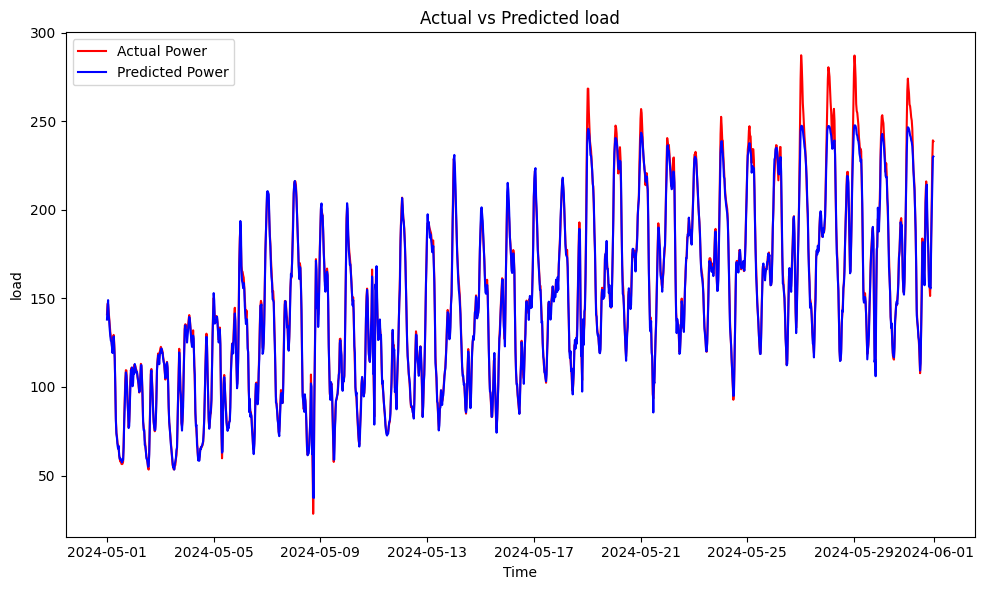

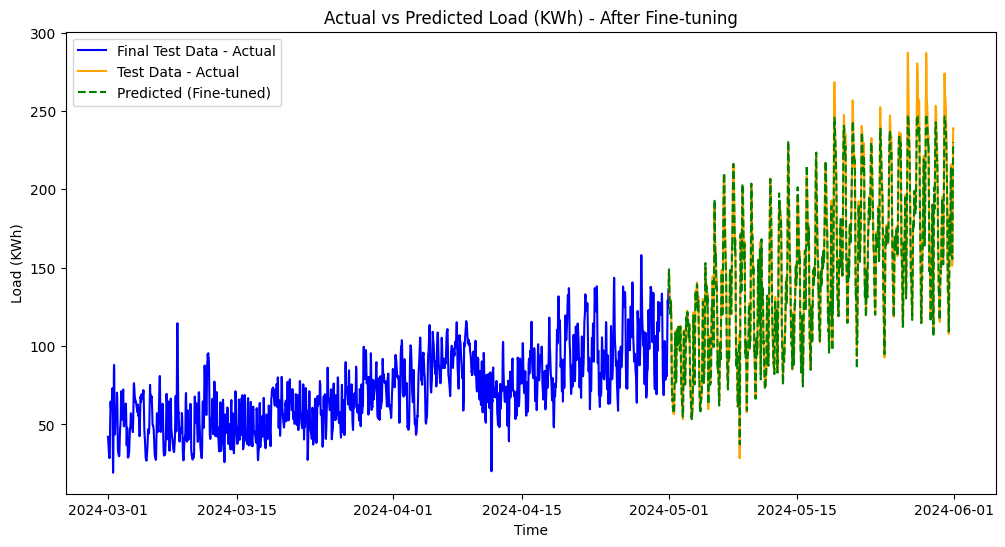

In [7]:
# Assuming 'base_model' is loaded and 'may_dataset' is preprocessed

# Separate features and labels
may_features, may_label = feature_label(may_dataset)
reshaped_may_features = reshape_fn(feature_scaler.transform(may_features))

# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fine-tune the model with May data
history = base_model.fit(
    reshaped_may_features, may_label,
    epochs=100,  # You can adjust this depending on the performance
    batch_size=64,
    validation_split=0.1,  # Use 10% of May data for validation
    callbacks=[early_stopping]
)

# Make predictions with the fine-tuned model
predicted_may = prediction(may_dataset, base_model)

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(may_dataset['KWh'], label="Test Data - Actual", color="orange")
plt.plot(may_dataset.index, predicted_may, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()



save fine tuned model


In [8]:
save_model(base_model, model_name="fine_tuned_may_lstm_model")

INFO:tensorflow:Assets written to: models\fine_tuned_may_lstm_model\assets


INFO:tensorflow:Assets written to: models\fine_tuned_may_lstm_model\assets


Model saved to: models\fine_tuned_may_lstm_model


test fine tuned model with june data 

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 12
Duplicated index: 0
null_values : 0
df rows after basic checks: 4355
null vlaues after resampling: 13
null values after filling: 0
from_date:  2024-04-01 to_date:  2024-06-30
holidays_lst: [datetime.date(2024, 4, 7), datetime.date(2024, 4, 10), datetime.date(2024, 4, 11), datetime.date(2024, 4, 14), datetime.date(2024, 4, 21), datetime.date(2024, 4, 28), datetime.date(2024, 5, 1), datetime.date(2024, 5, 5), datetime.date(2024, 5, 12), datetime.date(2024, 5, 19), datetime.date(2024, 5, 26), datetime.date(2024, 6, 2), datetime.date(2024, 6, 9), datetime.date(2024, 6, 16), datetime.date(2024, 6, 17), datetime.date(2024, 6, 23), datetime.date(2024, 6, 30)]
null values in final_df: 0


KWh  rolling_4  lag1_hour  lag2_hours  lag3_hours  \
creation_time                                                              
2024-06-01 00:00:00  246.8    241.500      241.1       235.3       199.8   
2024-06-01 00:30:00  256.0    242.500      226.1       252.0       228.3   
2024-06-01 01:00:00  247.8    244.175      246.8       241.1       235.3   
2024-06-01 01:30:00  245.2    248.950      256.0       226.1       252.0   
2024-06-01 02:00:00  254.1    250.775      247.8       246.8       241.1   
...                    ...        ...        ...         ...         ...   
2024-06-30 21:30:00  164.2    156.025      141.0       129.2       162.4   
2024-06-30 22:00:00  196.5    168.400      171.9       147.0       148.2   
2024-06-30 22:30:00  220.6    188.300      164.2       141.0       129.2   
2024-06-30 23:00:00  215.4    199.175      196.5       171.9       147.0   
2024-06-30 23:30:00  214.6    211.775      220.6       164.2       141.0   

                     lag1_day  lag7_days  lag_30_day   daily_avg  weekly_avg  \
creation_time                                                                  
2024-06-01 00:00:00     273.3      238.2       114.2  191.818750  189.175000   
2024-06-01 00:30:00     255.6      249.9       110.6  191.827083  189.193155   
2024-06-01 01:00:00     266.8      236.2       110.6  191.431250  189.227679   
2024-06-01 01:30:00     267.8      254.6       112.2  190.960417  189.199702   
2024-06-01 02:00:00     247.6      247.9       107.9  191.095833  189.218155   
...                       ...        ...         ...         ...         ...   
2024-06-30 21:30:00     139.6      203.8       228.3  149.452083  152.128869   
2024-06-30 22:00:00     162.1      213.8       235.3  150.168750  152.077381   
2024-06-30 22:30:00     165.5      215.4       252.0  151.316667  152.092857   
2024-06-30 23:00:00     177.0      212.7       241.1  152.116667  152.100893   
2024-06-30 23:30:00     180.6      235.9       226.1  152.825000  152.037500   

                     hour  day  dayofweek  weekofyear  holiday  \
creation_time                                                    
2024-06-01 00:00:00     0    1          5          22        0   
2024-06-01 00:30:00     0    1          5          22        0   
2024-06-01 01:00:00     1    1          5          22        0   
2024-06-01 01:30:00     1    1          5          22        0   
2024-06-01 02:00:00     2    1          5          22        0   
...                   ...  ...        ...         ...      ...   
2024-06-30 21:30:00    21   30          6          26        1   
2024-06-30 22:00:00    22   30          6          26        1   
2024-06-30 22:30:00    22   30          6          26        1   
2024-06-30 23:00:00    23   30          6          26        1   
2024-06-30 23:30:00    23   30          6          26        1   

                     apparent_temperature  rain  wind_speed_10m  \
creation_time                                                     
2024-06-01 00:00:00                 27.80  0.00            9.50   
2024-06-01 00:30:00                 29.60  0.00           11.95   
2024-06-01 01:00:00                 31.40  0.00           14.40   
2024-06-01 01:30:00                 32.80  0.00           15.40   
2024-06-01 02:00:00                 34.20  0.00           16.40   
...                                   ...   ...             ...   
2024-06-30 21:30:00                 31.40  0.15            8.70   
2024-06-30 22:00:00                 31.80  0.10            5.20   
2024-06-30 22:30:00                 31.45  0.60            7.00   
2024-06-30 23:00:00                 31.10  1.10            8.80   
2024-06-30 23:30:00                 31.45  1.70            5.70   

                     relative_humidity_2m  
creation_time                              
2024-06-01 00:00:00                  17.0  
2024-06-01 00:30:00                  15.5  
2024-06-01 01:00:00                  14.0  
2024-06-01 01:30:00                  15.0 

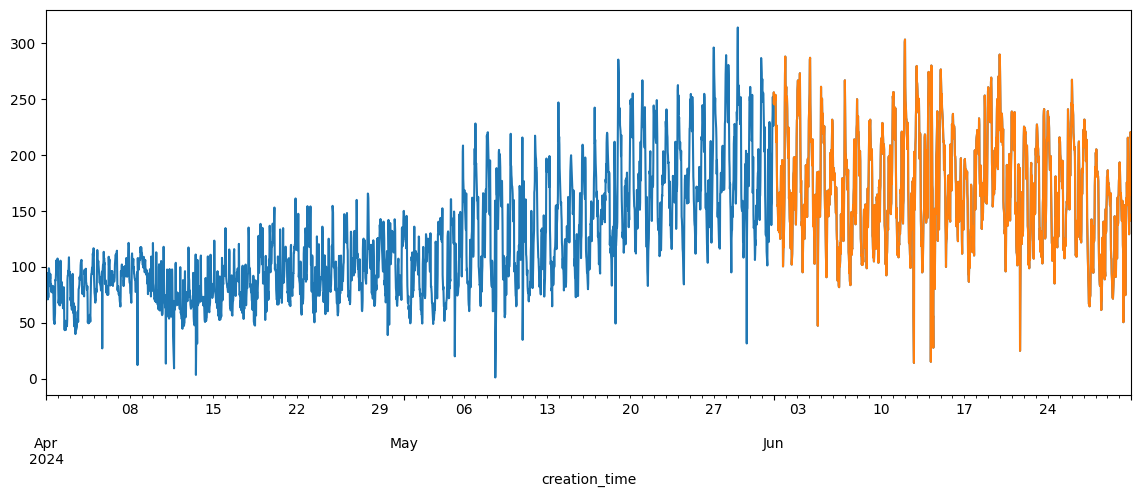

In [9]:
month = 6 # june
test_df = data_ingestion_training(month)
test_main_df = pre_process(test_df)
final_test_df = feature_engineering(test_main_df)
# final_df.set_index("creation_time",drop= True,inplace=True)
june_dataset = final_test_df.loc[final_test_df.index.month ==month]
june_dataset['KWh'].plot()
june_dataset

prediction on base model 

dataset_features shape: (1440, 18)
dataset_label shape: (1440,)
45/45 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 12.37442970726225
Root Mean Squared Error (RMSE): 18.16062955584859
R-squared: 0.8597752976541668


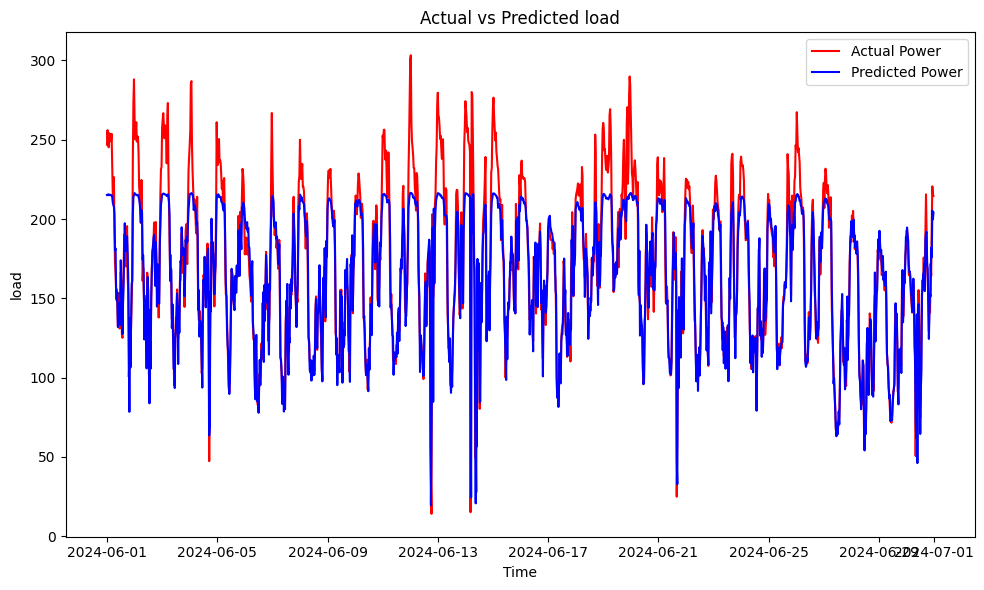

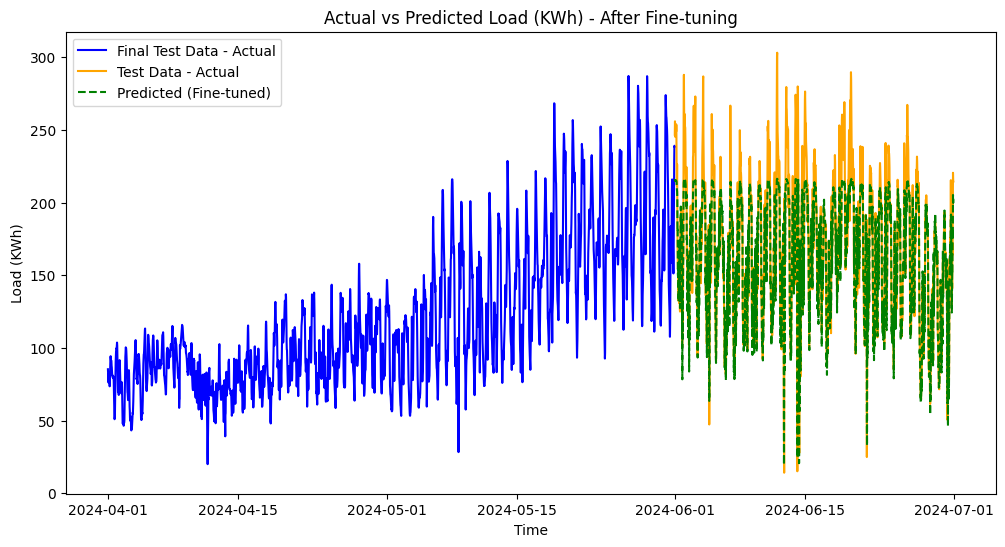

In [10]:
base_model_original = load_model("models/base_lstm")
dataset = june_dataset.copy()
predicted_june = prediction(dataset, base_model_original)
last_two_month_data = final_df.loc[(final_df.index.month.isin([4,5])) & (final_df.index.year == 2024)]

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
plt.plot(dataset.index, predicted_june, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()


prediction with fine tuned model with may data

dataset_features shape: (1440, 18)
dataset_label shape: (1440,)
45/45 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 9.650303379164802
Root Mean Squared Error (RMSE): 13.94343679606583
R-squared: 0.9173386693198817


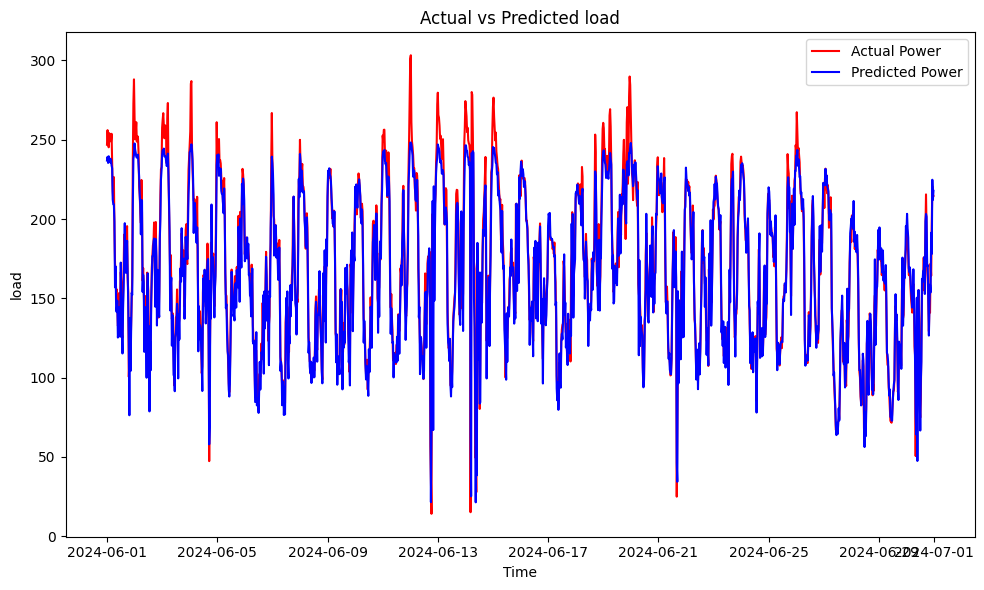

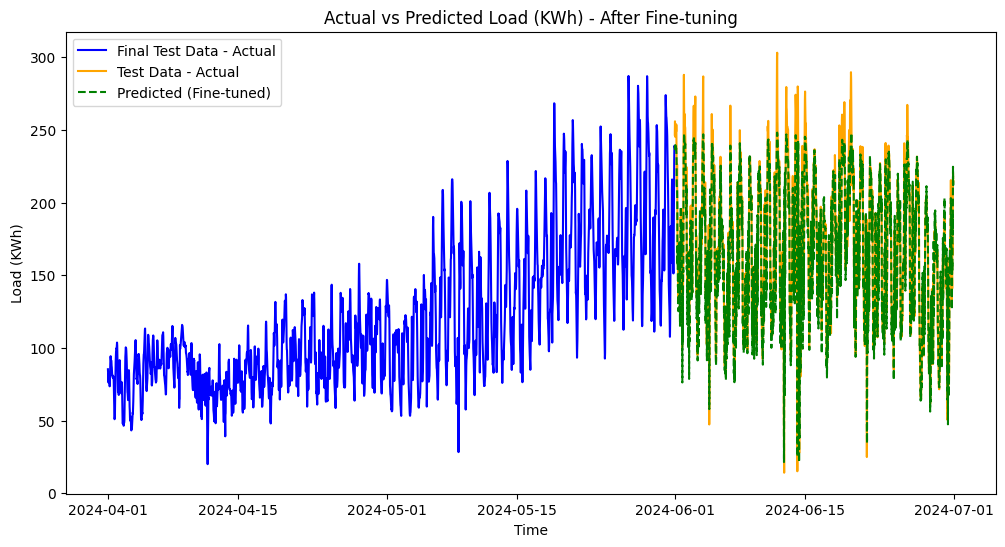

In [11]:
# base_model_original = load_model("models/base_lstm")
may_fine_tuned_model = load_model("models/fine_tuned_may_lstm_model")


dataset = june_dataset.copy()
predicted_june = prediction(dataset, may_fine_tuned_model)
last_two_month_data = final_df.loc[(final_df.index.month.isin([4,5])) & (final_df.index.year == 2024)]

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
plt.plot(dataset.index, predicted_june, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()


add june data in fine tuned model

In [12]:
may_fine_tuned_model = load_model("models/fine_tuned_may_lstm_model")
# Separate features and labels
june_features, june_label = feature_label(june_dataset)
reshaped_june_features = reshape_fn(feature_scaler.transform(june_features))

# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fine-tune the model with May data
history = may_fine_tuned_model.fit(
    reshaped_june_features, june_label,
    epochs=100,  # You can adjust this depending on the performance
    batch_size=64,
    validation_split=0.1,  # Use 10% of May data for validation
    callbacks=[early_stopping]
)
save_model(may_fine_tuned_model, model_name="fine_tuned_june_lstm_model")

dataset_features shape: (1440, 18)
dataset_label shape: (1440,)
Epoch 1/100
21/21 [==============================] - 3s 30ms/step - loss: 399.3977 - val_loss: 128.5568
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 394.3497 - val_loss: 135.4093
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 394.9679 - val_loss: 124.7163
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 392.8347 - val_loss: 131.4925
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 394.2432 - val_loss: 125.9175
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 377.2025 - val_loss: 125.3953
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 407.3000 - val_loss: 122.9080
Epoch 8/100
21/21 [==============================] - 0s 4ms/step - loss: 401.6526 - val_loss: 132.2569
Epoch 9/100
21/21 [==============================] - 0s 4ms/step - loss: 377.5363 - val_loss: 127.5235
Epoch 10

INFO:tensorflow:Assets written to: models\fine_tuned_june_lstm_model\assets


INFO:tensorflow:Assets written to: models\fine_tuned_june_lstm_model\assets


Model saved to: models\fine_tuned_june_lstm_model


testing on july dataset

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 9
Duplicated index: 0
null_values : 0
df rows after basic checks: 4406
null vlaues after resampling: 10
null values after filling: 0
from_date:  2024-05-01 to_date:  2024-07-31
holidays_lst: [datetime.date(2024, 5, 1), datetime.date(2024, 5, 5), datetime.date(2024, 5, 12), datetime.date(2024, 5, 19), datetime.date(2024, 5, 26), datetime.date(2024, 6, 2), datetime.date(2024, 6, 9), datetime.date(2024, 6, 16), datetime.date(2024, 6, 17), datetime.date(2024, 6, 23), datetime.date(2024, 6, 30), datetime.date(2024, 7, 7), datetime.date(2024, 7, 14), datetime.date(2024, 7, 16), datetime.date(2024, 7, 21), datetime.date(2024, 7, 28)]
null values in final_df: 0


KWh  rolling_4  lag1_hour  lag2_hours  lag3_hours  \
creation_time                                                              
2024-07-01 00:00:00  225.2    218.950      215.4       196.5       171.9   
2024-07-01 00:30:00  239.3    223.625      214.6       220.6       164.2   
2024-07-01 01:00:00  241.8    230.225      225.2       215.4       196.5   
2024-07-01 01:30:00  219.6    231.475      239.3       214.6       220.6   
2024-07-01 02:00:00  215.8    229.125      241.8       225.2       215.4   
...                    ...        ...        ...         ...         ...   
2024-07-31 21:30:00  118.5    113.300      106.4       127.2       192.2   
2024-07-31 22:00:00  125.9    115.900      112.8       115.5       163.1   
2024-07-31 22:30:00  169.8    131.750      118.5       106.4       127.2   
2024-07-31 23:00:00  224.8    159.750      125.9       112.8       115.5   
2024-07-31 23:30:00  105.5    156.500      169.8       118.5       106.4   

                     lag1_day  lag7_days  lag_30_day   daily_avg  weekly_avg  \
creation_time                                                                  
2024-07-01 00:00:00     192.5      239.3       246.8  153.506250  151.995536   
2024-07-01 00:30:00     193.4      235.4       256.0  154.462500  152.007143   
2024-07-01 01:00:00     188.8      233.5       247.8  155.566667  152.031845   
2024-07-01 01:30:00     175.8      233.9       245.2  156.479167  151.989286   
2024-07-01 02:00:00     164.8      230.4       254.1  157.541667  151.945833   
...                       ...        ...         ...         ...         ...   
2024-07-31 21:30:00     288.8      198.6       190.1  205.712500  179.858631   
2024-07-31 22:00:00     271.3      211.5       189.9  202.683333  179.603869   
2024-07-31 22:30:00     290.7      226.0       207.4  200.164583  179.436607   
2024-07-31 23:00:00     306.0      266.3       239.0  198.472917  179.313095   
2024-07-31 23:30:00     349.3      286.7       255.3  193.393750  178.773810   

                     hour  day  dayofweek  weekofyear  holiday  \
creation_time                                                    
2024-07-01 00:00:00     0    1          0          27        0   
2024-07-01 00:30:00     0    1          0          27        0   
2024-07-01 01:00:00     1    1          0          27        0   
2024-07-01 01:30:00     1    1          0          27        0   
2024-07-01 02:00:00     2    1          0          27        0   
...                   ...  ...        ...         ...      ...   
2024-07-31 21:30:00    21   31          2          31        0   
2024-07-31 22:00:00    22   31          2          31        0   
2024-07-31 22:30:00    22   31          2          31        0   
2024-07-31 23:00:00    23   31          2          31        0   
2024-07-31 23:30:00    23   31          2          31        0   

                     apparent_temperature  rain  wind_speed_10m  \
creation_time                                                     
2024-07-01 00:00:00                 31.80  2.30            2.60   
2024-07-01 00:30:00                 33.30  1.15            2.40   
2024-07-01 01:00:00                 34.80  0.00            2.20   
2024-07-01 01:30:00                 35.35  0.00            2.75   
2024-07-01 02:00:00                 35.90  0.00            3.30   
...                                   ...   ...             ...   
2024-07-31 21:30:00                 31.30  3.80           14.20   
2024-07-31 22:00:00                 30.10  4.10           18.40   
2024-07-31 22:30:00                 30.15  2.70           18.00   
2024-07-31 23:00:00                 30.20  1.30           17.60   
2024-07-31 23:30:00                 31.05  1.40           13.45   

                     relative_humidity_2m  
creation_time                              
2024-07-01 00:00:00                  94.0  
2024-07-01 00:30:00                  91.5  
2024-07-01 01:00:00                  89.0  
2024-07-01 01:30:00                  86.5 

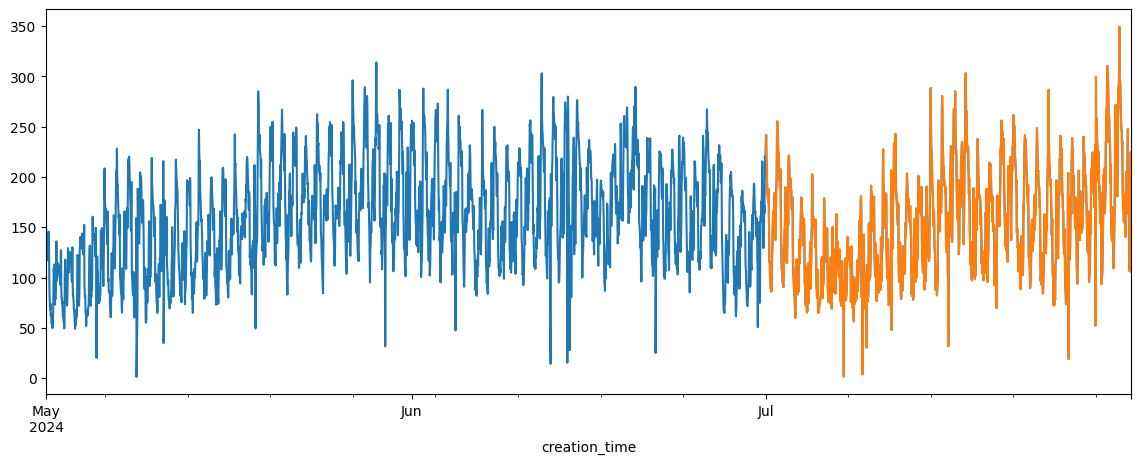

In [13]:
month = 7 # july
test_df = data_ingestion_training(month)
test_main_df = pre_process(test_df)
final_test_df = feature_engineering(test_main_df)
# final_df.set_index("creation_time",drop= True,inplace=True)
july_dataset = final_test_df.loc[final_test_df.index.month ==month]
july_dataset['KWh'].plot()
july_dataset

prediction with base model

dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
47/47 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 11.064478465818592
Root Mean Squared Error (RMSE): 17.47885043669834
R-squared: 0.8893134757251224


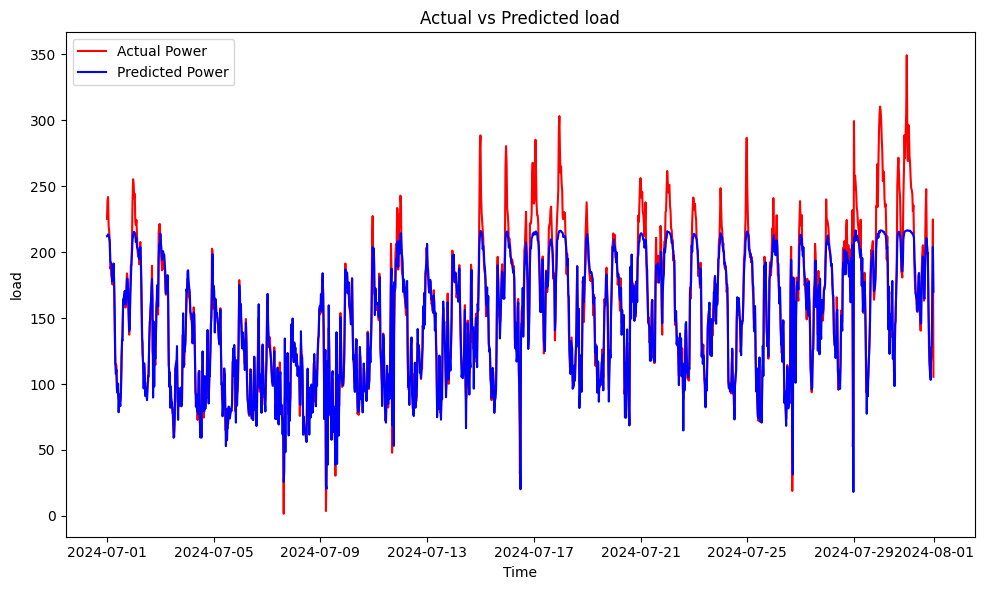

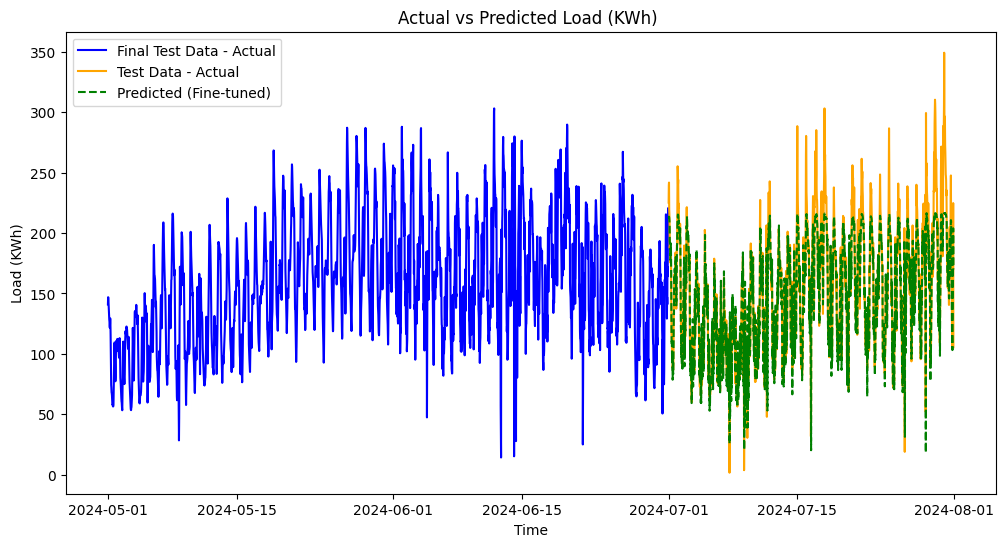

In [14]:
dataset = july_dataset.copy()
predicted_july = prediction(dataset, base_model_original)
last_two_month_data = pd.concat((final_df.loc[(final_df.index.month.isin([5,6])) & (final_df.index.year == 2024)],june_dataset))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
plt.plot(dataset.index, predicted_july, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) ")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()


prediction with may fine tuned model

dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
47/47 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 8.948849777765172
Root Mean Squared Error (RMSE): 13.242756032830634
R-squared: 0.9364631361786351


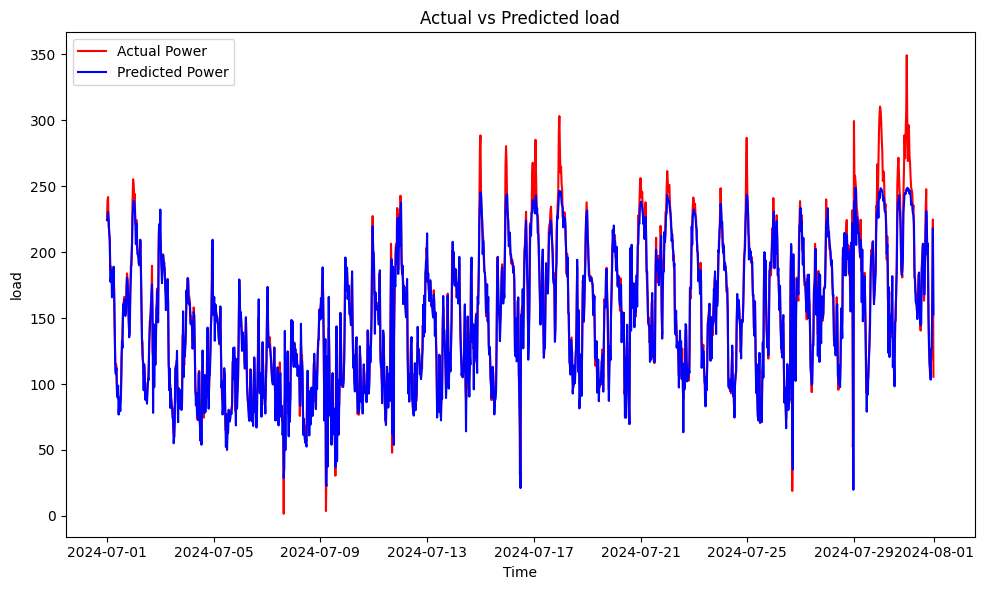

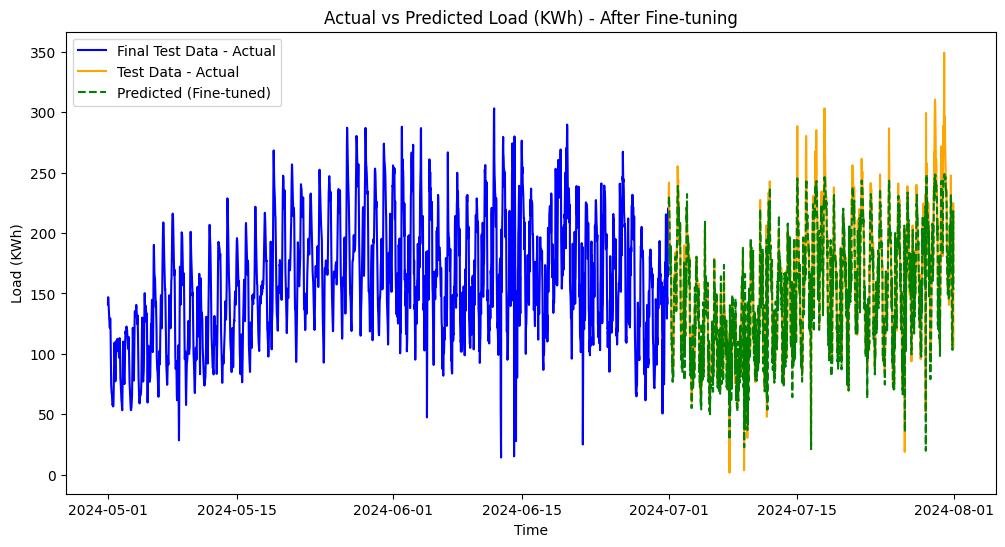

In [15]:
may_fine_tuned_model = load_model("models/fine_tuned_may_lstm_model")

dataset = july_dataset.copy()
predicted_july = prediction(dataset, may_fine_tuned_model)
last_two_month_data = pd.concat((final_df.loc[(final_df.index.month.isin([5,6])) & (final_df.index.year == 2024)],june_dataset))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
plt.plot(dataset.index, predicted_july, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()


prediction with june fine tuned model

dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
47/47 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 8.373048248598653
Root Mean Squared Error (RMSE): 12.33209407295699
R-squared: 0.9449011320852633


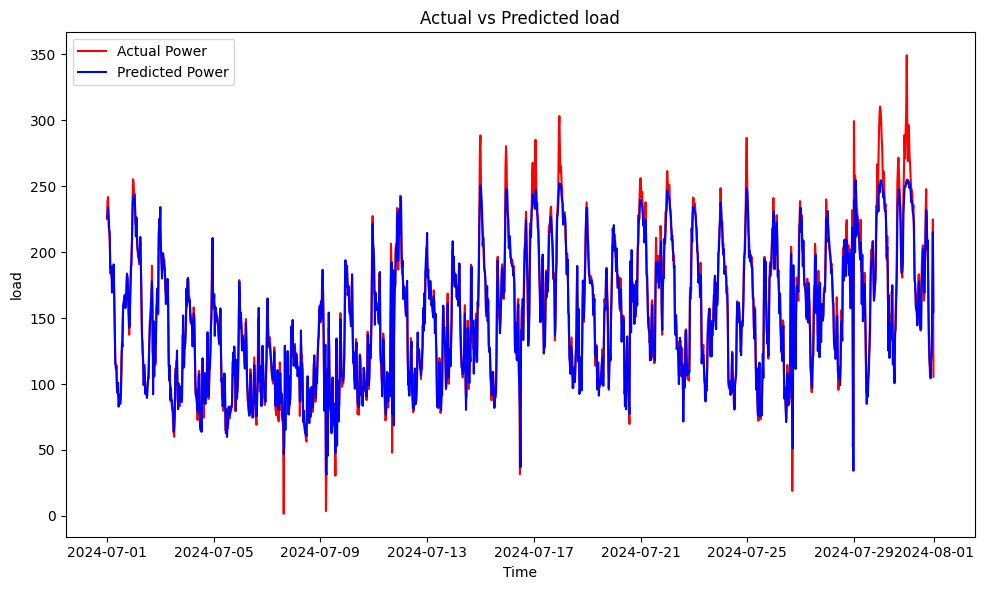

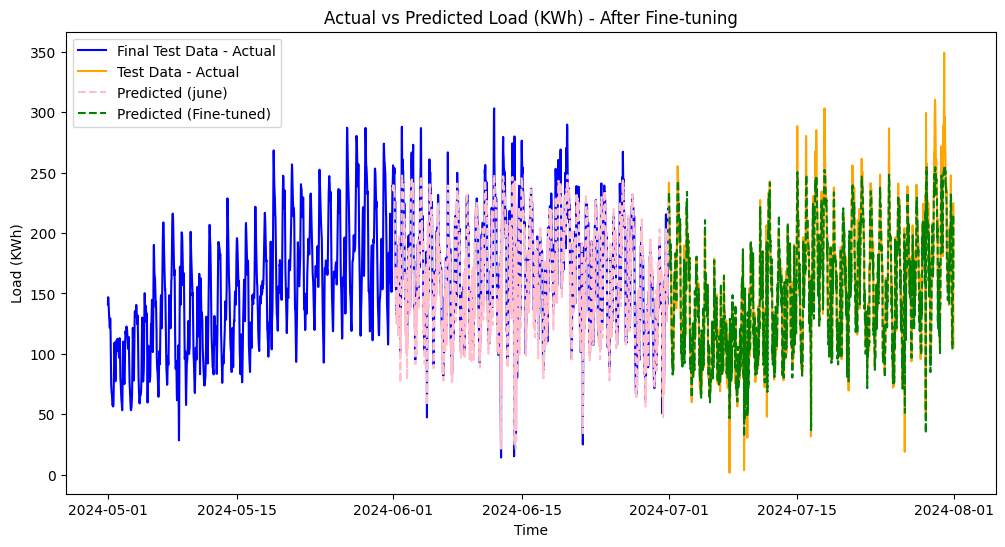

In [16]:
june_fine_tuned_model = load_model("models/fine_tuned_june_lstm_model")
dataset = july_dataset.copy()
predicted_july = prediction(dataset, june_fine_tuned_model)
last_two_month_data = pd.concat((final_df.loc[(final_df.index.month.isin([5,6])) & (final_df.index.year == 2024)],june_dataset))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
plt.plot(june_dataset.index, predicted_june, label="Predicted (june)", color="pink", linestyle="--")
plt.plot(dataset.index, predicted_july, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()


fine tunning with july data (june fine tuned model)

In [17]:
june_fine_tuned_model = load_model("models/fine_tuned_june_lstm_model")
# Separate features and labels
july_features, july_label = feature_label(july_dataset)
reshaped_july_features = reshape_fn(feature_scaler.transform(july_features))

# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fine-tune the model with May data
history = june_fine_tuned_model.fit(
    reshaped_july_features, july_label,
    epochs=100,  # You can adjust this depending on the performance
    batch_size=64,
    validation_split=0.1,  # Use 10% of May data for validation
    callbacks=[early_stopping]
)
save_model(june_fine_tuned_model, model_name="fine_tuned_july_lstm_model")

dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
Epoch 1/100
21/21 [==============================] - 3s 34ms/step - loss: 269.1475 - val_loss: 512.7402
Epoch 2/100
21/21 [==============================] - 0s 5ms/step - loss: 272.4199 - val_loss: 501.8786
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 276.1718 - val_loss: 502.1871
Epoch 4/100
21/21 [==============================] - 0s 5ms/step - loss: 282.7232 - val_loss: 499.6158
Epoch 5/100
21/21 [==============================] - 0s 5ms/step - loss: 270.1930 - val_loss: 505.5569
Epoch 6/100
21/21 [==============================] - 0s 5ms/step - loss: 279.6667 - val_loss: 514.7556
Epoch 7/100
21/21 [==============================] - 0s 5ms/step - loss: 264.5880 - val_loss: 512.1797
Epoch 8/100
21/21 [==============================] - 0s 5ms/step - loss: 287.8955 - val_loss: 512.6769
Epoch 9/100
21/21 [==============================] - 0s 5ms/step - loss: 276.0564 - val_loss: 509.4639
Epoch 10

INFO:tensorflow:Assets written to: models\fine_tuned_july_lstm_model\assets


INFO:tensorflow:Assets written to: models\fine_tuned_july_lstm_model\assets


Model saved to: models\fine_tuned_july_lstm_model


dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
47/47 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 8.161660993227395
Root Mean Squared Error (RMSE): 12.035076053096956
R-squared: 0.9475232783404977


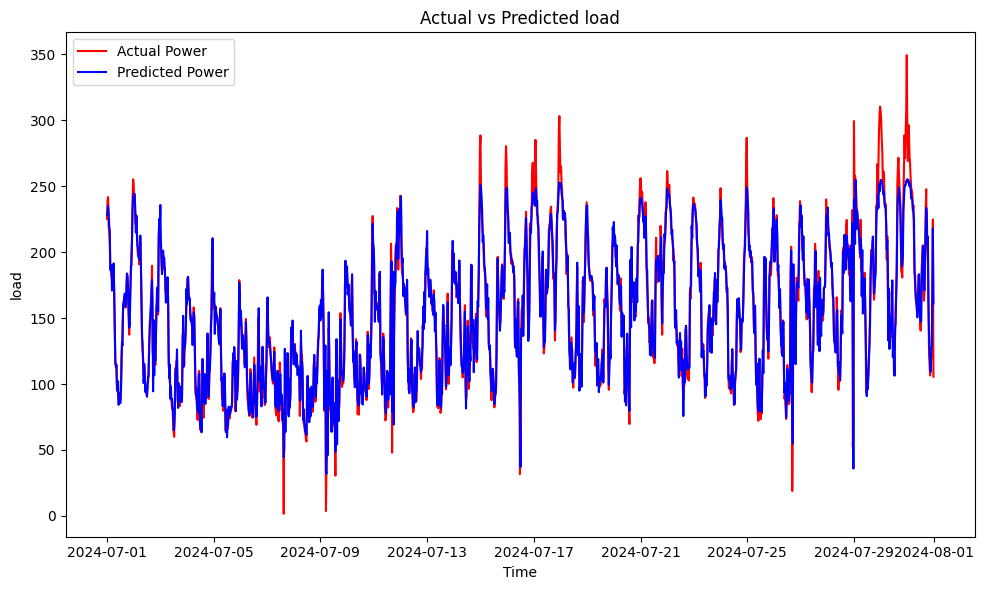

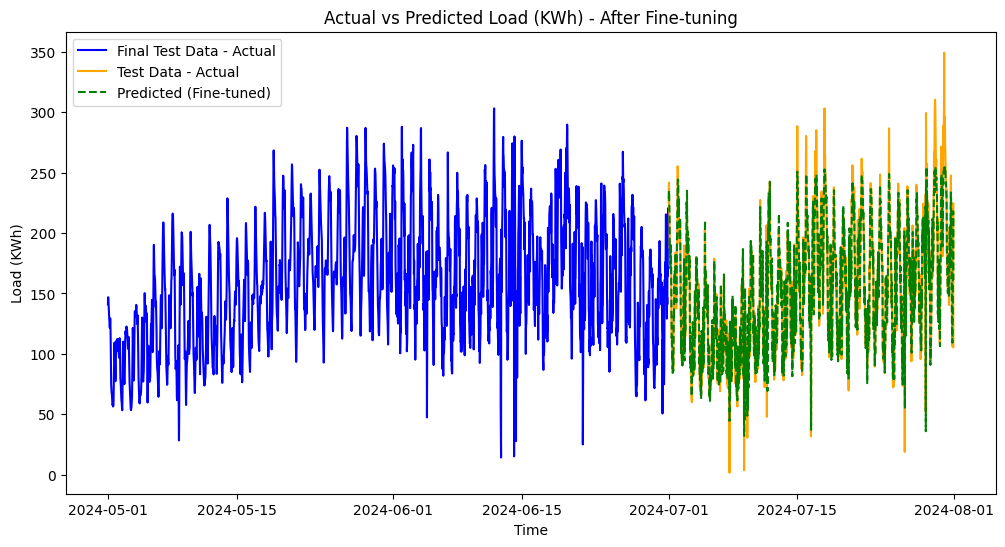

In [18]:
july_fine_tuned_model = load_model("models/fine_tuned_july_lstm_model")
dataset = july_dataset.copy()
predicted_july = prediction(dataset, july_fine_tuned_model)
last_two_month_data = pd.concat((final_df.loc[(final_df.index.month.isin([5,6])) & (final_df.index.year == 2024)],june_dataset))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
# plt.plot(june_dataset.index, predicted_june, label="Predicted (june)", color="pink", linestyle="--")
plt.plot(dataset.index, predicted_july, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()


testing on august dataset

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 8
Duplicated index: 0
null_values : 0
df rows after basic checks: 4407
null vlaues after resampling: 9
null values after filling: 0
from_date:  2024-06-01 to_date:  2024-08-31
holidays_lst: [datetime.date(2024, 6, 2), datetime.date(2024, 6, 9), datetime.date(2024, 6, 16), datetime.date(2024, 6, 17), datetime.date(2024, 6, 23), datetime.date(2024, 6, 30), datetime.date(2024, 7, 7), datetime.date(2024, 7, 14), datetime.date(2024, 7, 16), datetime.date(2024, 7, 21), datetime.date(2024, 7, 28), datetime.date(2024, 8, 4), datetime.date(2024, 8, 11), datetime.date(2024, 8, 15), datetime.date(2024, 8, 18), datetime.date(2024, 8, 25)]
null values in final_df: 0


KWh   rolling_4   lag1_hour  lag2_hours  \
creation_time                                                         
2024-08-01 00:00:00  131.566667  157.916667  224.800000  125.900000   
2024-08-01 00:30:00  157.633333  154.875000  105.500000  169.800000   
2024-08-01 01:00:00  183.700000  144.600000  131.566667  224.800000   
2024-08-01 01:30:00  251.900000  181.200000  157.633333  105.500000   
2024-08-01 02:00:00  195.400000  197.158333  183.700000  131.566667   
...                         ...         ...         ...         ...   
2024-08-31 21:30:00  161.900000  132.950000  121.100000  115.500000   
2024-08-31 22:00:00  197.600000  150.050000  119.600000  129.200000   
2024-08-31 22:30:00  198.300000  169.350000  161.900000  121.100000   
2024-08-31 23:00:00  229.200000  196.750000  197.600000  119.600000   
2024-08-31 23:30:00  204.900000  207.500000  198.300000  161.900000   

                     lag3_hours  lag1_day  lag7_days  lag_30_day   daily_avg  \
creation_time                                                                  
2024-08-01 00:00:00       112.8     295.6      250.0       251.6  189.976389   
2024-08-01 00:30:00       118.5     269.1      228.9       240.9  187.654167   
2024-08-01 01:00:00       125.9     296.5      214.4       244.2  185.304167   
2024-08-01 01:30:00       169.8     291.9      211.8       222.6  184.470833   
2024-08-01 02:00:00       224.8     272.8      202.7       220.7  182.858333   
...                         ...       ...        ...         ...         ...   
2024-08-31 21:30:00       104.8     128.3      164.4       150.6  127.995833   
2024-08-31 22:00:00        98.7     165.2      146.5       153.1  128.670833   
2024-08-31 22:30:00       115.5     189.0      159.8       168.9  128.864583   
2024-08-31 23:00:00       129.2     202.4      172.2       189.4  129.422917   
2024-08-31 23:30:00       121.1     159.4      189.9       219.5  130.370833   

                     weekly_avg  hour  day  dayofweek  weekofyear  holiday  \
creation_time                                                                
2024-08-01 00:00:00  178.421329     0    1          3          31        0   
2024-08-01 00:30:00  178.209226     0    1          3          31        0   
2024-08-01 01:00:00  178.117857     1    1          3          31        0   
2024-08-01 01:30:00  178.237202     1    1          3          31        0   
2024-08-01 02:00:00  178.215476     2    1          3          31        0   
...                         ...   ...  ...        ...         ...      ...   
2024-08-31 21:30:00  117.849405    21   31          5          35        0   
2024-08-31 22:00:00  118.001488    22   31          5          35        0   
2024-08-31 22:30:00  118.116071    22   31          5          35        0   
2024-08-31 23:00:00  118.285714    23   31          5          35        0   
2024-08-31 23:30:00  118.330357    23   31          5          35        0   

                     apparent_temperature  rain  wind_speed_10m  \
creation_time                                                     
2024-08-01 00:00:00                  31.9  1.50            9.30   
2024-08-01 00:30:00                  31.8  1.35            6.90   
2024-08-01 01:00:00                  31.7  1.20            4.50   
2024-08-01 01:30:00                  31.9  1.55            4.35   
2024-08-01 02:00:00                  32.1  1.90            4.20   
...                                   ...   ...             ...   
2024-08-31 21:30:00                  32.3  0.00            5.20   
2024-08-31 22:00:00                  32.1  0.00            5.80   
2024-08-31 22:30:00                  32.0  0.00            5.85   
2024-08-31 23:00:00                  31.9  0.00            5.90   
2024-08-31 23:30:00                  31.8  0.00            5.65   

                     relative_humidity_2m  
creation_time                              
2024-08-01 00:00:00                  97.0  
2024-08-01 00:30:00                  96.0  


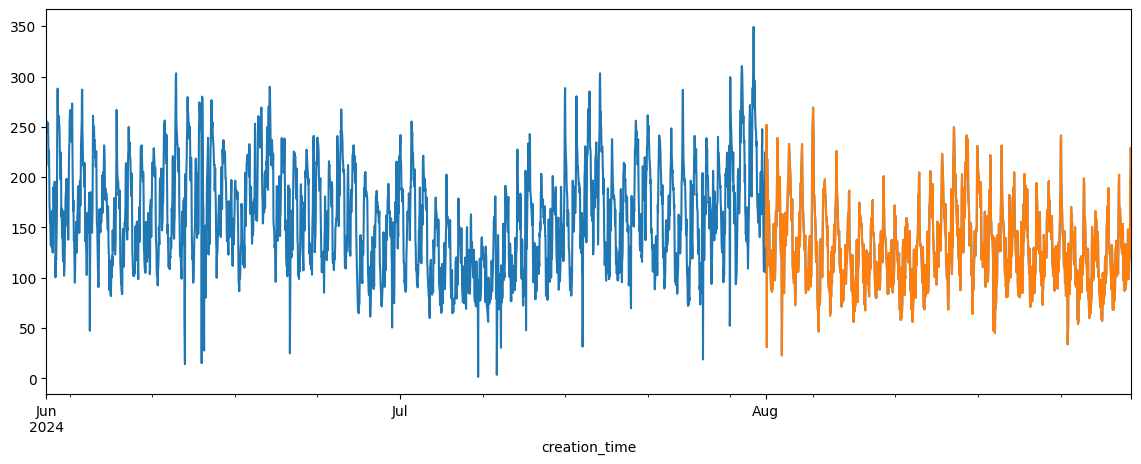

In [19]:
month = 8 # august
test_df = data_ingestion_training(month)
test_main_df = pre_process(test_df)
final_test_df = feature_engineering(test_main_df)
# final_df.set_index("creation_time",drop= True,inplace=True)
august_dataset = final_test_df.loc[final_test_df.index.month ==month]
august_dataset['KWh'].plot()
august_dataset

prediction with june fine tuned model

dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
47/47 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 7.211147531215436
Root Mean Squared Error (RMSE): 10.543096057305466
R-squared: 0.9266964674598547


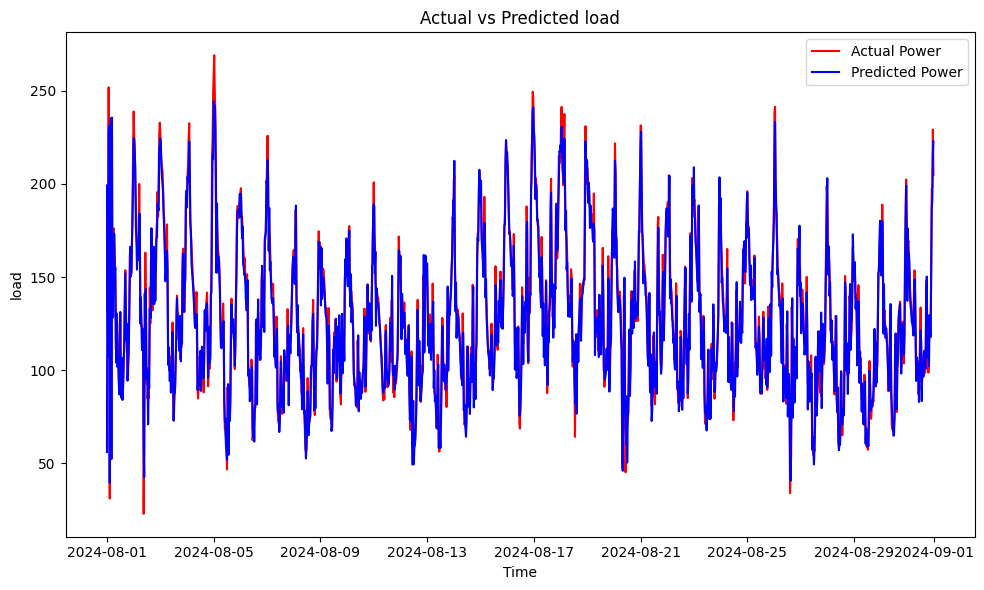

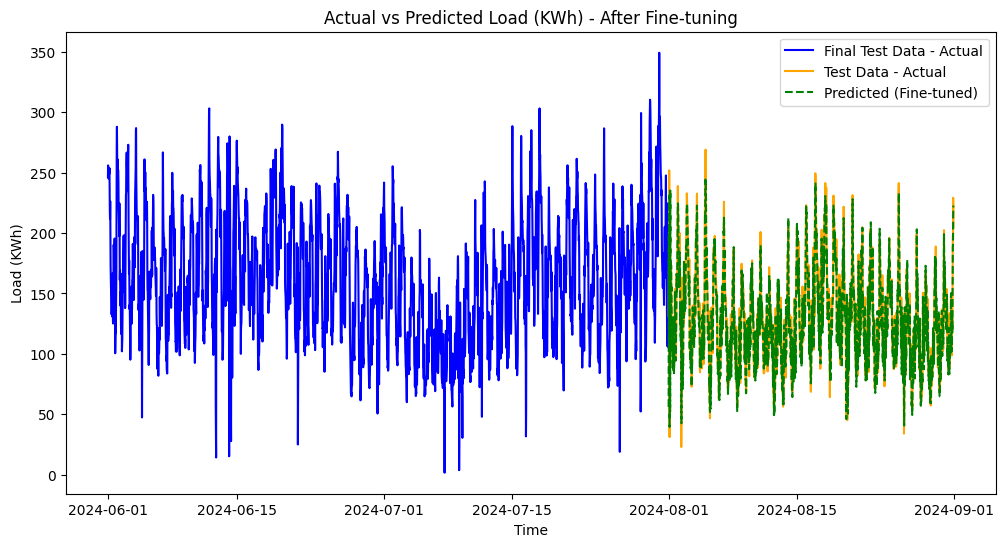

In [20]:
june_fine_tuned_model = load_model("models/fine_tuned_june_lstm_model")
dataset = august_dataset.copy()
predicted_august = prediction(dataset, june_fine_tuned_model)
last_two_month_data = pd.concat((june_dataset,july_dataset))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
plt.plot(dataset.index, predicted_august, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()


prediction with july fine tuned model


dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
47/47 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 6.911843778582885
Root Mean Squared Error (RMSE): 10.194039910510144
R-squared: 0.9314699203718422


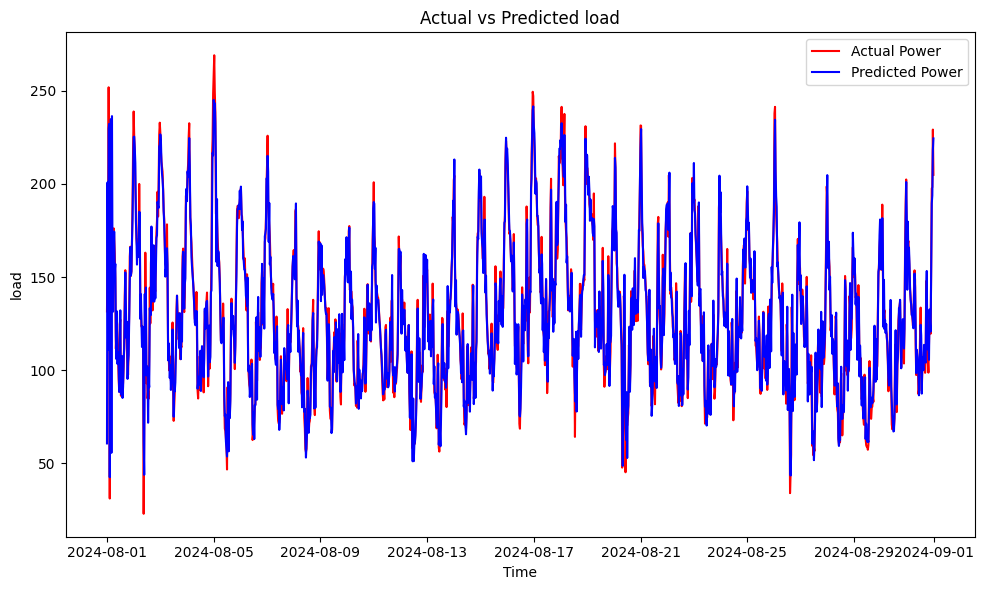

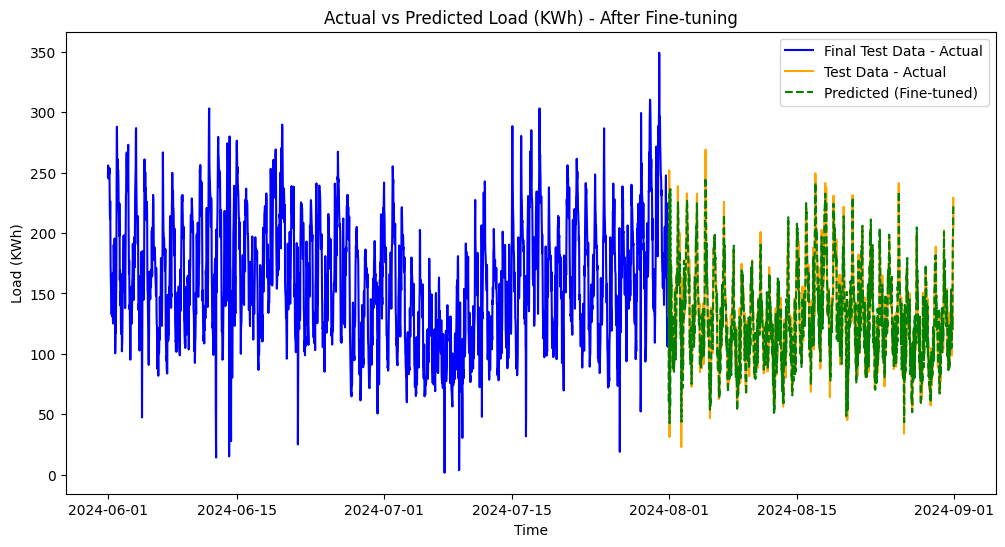

In [21]:
july_fine_tuned_model = load_model("models/fine_tuned_july_lstm_model")
dataset = august_dataset.copy()
predicted_august = prediction(dataset, july_fine_tuned_model)
last_two_month_data = pd.concat((june_dataset,july_dataset))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
# plt.plot(june_dataset.index, predicted_august, label="Predicted (june)", color="pink", linestyle="--")
plt.plot(dataset.index, predicted_august, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()


fine tunning with august data (july fine tuned model)

In [22]:
july_fine_tuned_model = load_model("models/fine_tuned_july_lstm_model")
# Separate features and labels
august_features, august_label = feature_label(august_dataset)
reshaped_august_features = reshape_fn(feature_scaler.transform(august_features))

# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fine-tune the model with May data
history = june_fine_tuned_model.fit(
    reshaped_august_features, august_label,
    epochs=100,  # You can adjust this depending on the performance
    batch_size=64,
    validation_split=0.1,  # Use 10% of May data for validation
    callbacks=[early_stopping]
)
save_model(july_fine_tuned_model, model_name="fine_tuned_august_lstm_model")

dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
Epoch 1/100
21/21 [==============================] - 3s 35ms/step - loss: 239.0903 - val_loss: 84.7928
Epoch 2/100
21/21 [==============================] - 0s 7ms/step - loss: 218.2609 - val_loss: 73.3426
Epoch 3/100
21/21 [==============================] - 0s 8ms/step - loss: 229.5060 - val_loss: 73.5209
Epoch 4/100
21/21 [==============================] - 0s 7ms/step - loss: 230.9111 - val_loss: 81.6246
Epoch 5/100
21/21 [==============================] - 0s 7ms/step - loss: 225.4729 - val_loss: 77.1737
Epoch 6/100
21/21 [==============================] - 0s 7ms/step - loss: 234.4920 - val_loss: 74.1035
Epoch 7/100
21/21 [==============================] - 0s 7ms/step - loss: 236.0532 - val_loss: 75.8901
Epoch 8/100
21/21 [==============================] - 0s 7ms/step - loss: 220.1714 - val_loss: 78.0624
Epoch 9/100
21/21 [==============================] - 0s 8ms/step - loss: 215.0141 - val_loss: 86.2855
Epoch 10/100
21/2

INFO:tensorflow:Assets written to: models\fine_tuned_august_lstm_model\assets


INFO:tensorflow:Assets written to: models\fine_tuned_august_lstm_model\assets


Model saved to: models\fine_tuned_august_lstm_model


dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
47/47 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 6.911843778582885
Root Mean Squared Error (RMSE): 10.194039910510144
R-squared: 0.9314699203718422


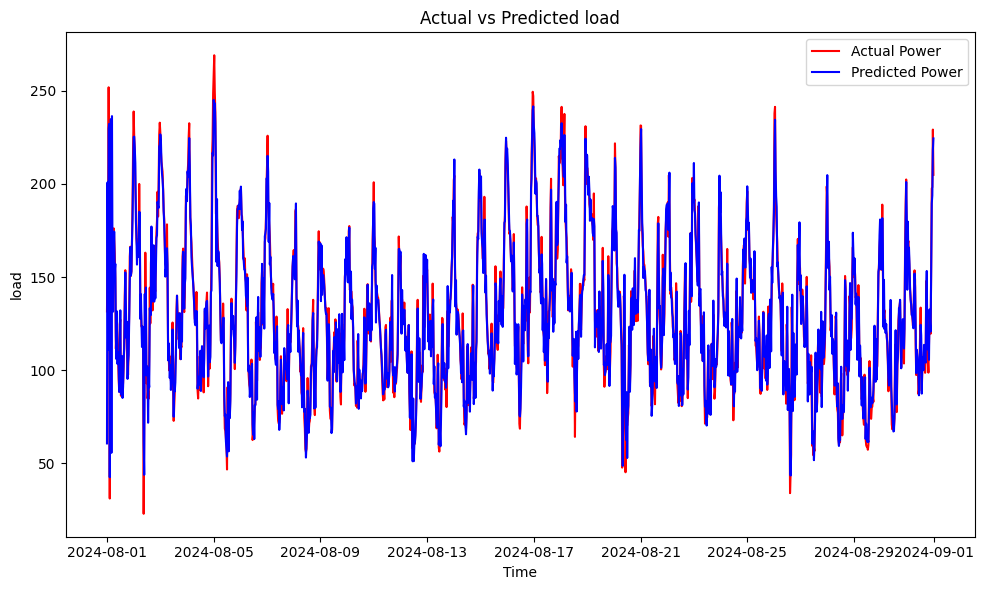

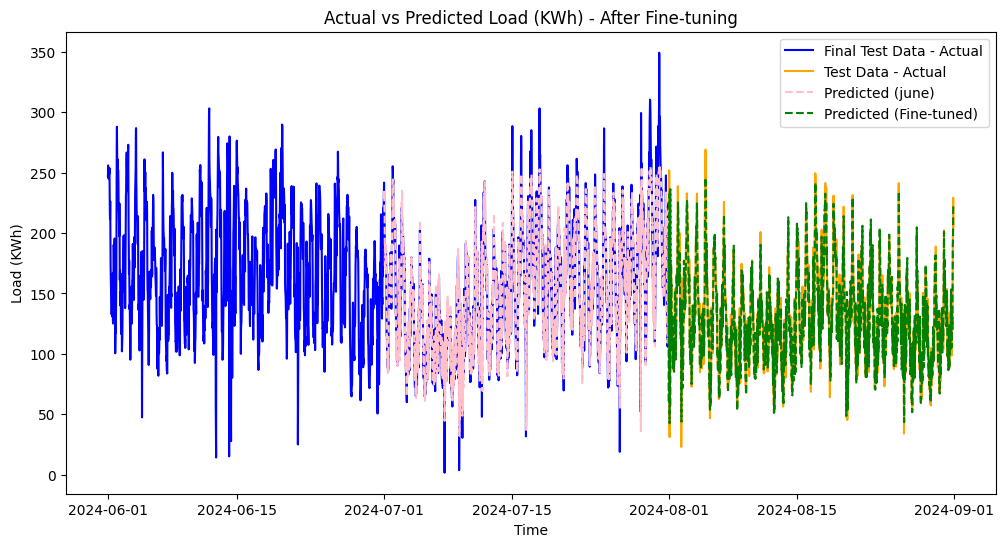

In [23]:
august_fine_tuned_model = load_model("models/fine_tuned_august_lstm_model")
dataset = august_dataset.copy()
predicted_august = prediction(dataset, august_fine_tuned_model)
last_two_month_data = pd.concat((june_dataset,july_dataset))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
plt.plot(july_dataset.index, predicted_july, label="Predicted (june)", color="pink", linestyle="--")
plt.plot(dataset.index, predicted_august, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()


dataset_features shape: (48, 18)
dataset_label shape: (48,)
2/2 [==============================] - 0s 3ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 7.13837455113729
Root Mean Squared Error (RMSE): 10.011436851990561
R-squared: 0.96509210297195


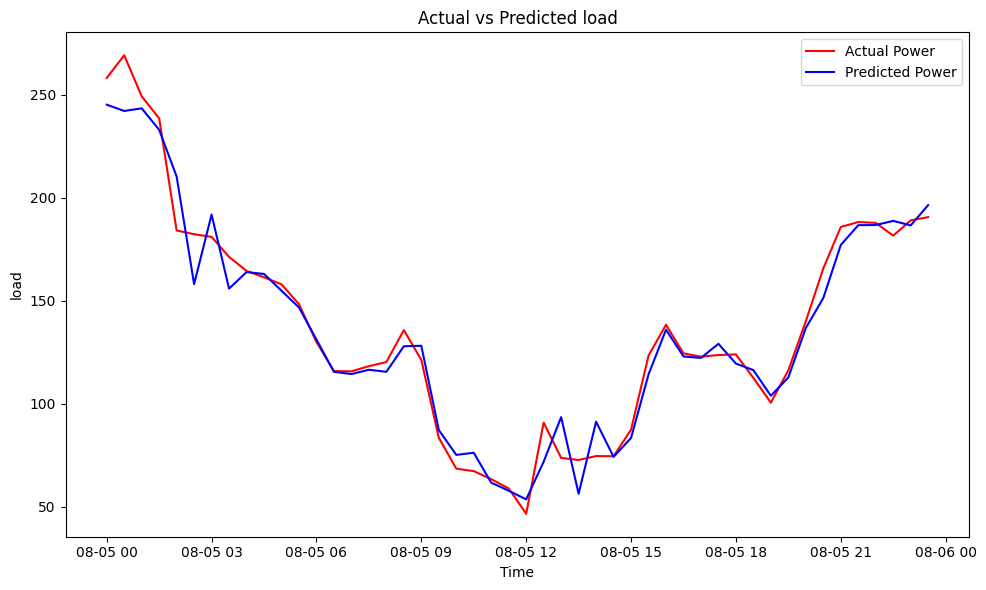

In [24]:
predicted_august = prediction(day_wise_prediction(dataset,5), august_fine_tuned_model)


september testing

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 6
Duplicated index: 0
null_values : 0
df rows after basic checks: 4409
null vlaues after resampling: 7
null values after filling: 0
from_date:  2024-07-01 to_date:  2024-09-30
holidays_lst: [datetime.date(2024, 7, 7), datetime.date(2024, 7, 14), datetime.date(2024, 7, 16), datetime.date(2024, 7, 21), datetime.date(2024, 7, 28), datetime.date(2024, 8, 4), datetime.date(2024, 8, 11), datetime.date(2024, 8, 15), datetime.date(2024, 8, 18), datetime.date(2024, 8, 25), datetime.date(2024, 9, 1), datetime.date(2024, 9, 8), datetime.date(2024, 9, 15), datetime.date(2024, 9, 22), datetime.date(2024, 9, 29)]
null values in final_df: 0


KWh  rolling_4  lag1_hour  lag2_hours  lag3_hours  \
creation_time                                                              
2024-09-01 00:00:00  193.0    206.350      229.2       197.6       119.6   
2024-09-01 00:30:00  216.9    211.000      204.9       198.3       161.9   
2024-09-01 01:00:00  214.5    207.325      193.0       229.2       197.6   
2024-09-01 01:30:00  196.8    205.300      216.9       204.9       198.3   
2024-09-01 02:00:00  182.5    202.675      214.5       193.0       229.2   
...                    ...        ...        ...         ...         ...   
2024-09-30 21:30:00  104.6    103.550      105.2       118.0       114.1   
2024-09-30 22:00:00  124.2    109.675      104.7        99.7       130.0   
2024-09-30 22:30:00  149.2    120.675      104.6       105.2       118.0   
2024-09-30 23:00:00  153.2    132.800      124.2       104.7        99.7   
2024-09-30 23:30:00  143.7    142.575      149.2       104.6       105.2   

                     lag1_day  lag7_days  lag_30_day   daily_avg  weekly_avg  \
creation_time                                                                  
2024-09-01 00:00:00     161.0      196.1       238.9  131.037500  118.321131   
2024-09-01 00:30:00     167.7      180.9       225.5  132.062500  118.428274   
2024-09-01 01:00:00     169.4      175.2       217.7  133.002083  118.545238   
2024-09-01 01:30:00     161.9      176.7       199.1  133.729167  118.605060   
2024-09-01 02:00:00     152.6      159.1       189.2  134.352083  118.674702   
...                       ...        ...         ...         ...         ...   
2024-09-30 21:30:00     108.3      160.6       161.9  101.154167  112.084226   
2024-09-30 22:00:00     114.3      186.5       197.6  101.360417  111.898810   
2024-09-30 22:30:00     115.2      200.5       198.3  102.068750  111.746131   
2024-09-30 23:00:00     129.6      211.2       229.2  102.560417  111.573512   
2024-09-30 23:30:00     139.2      227.9       204.9  102.654167  111.322917   

                     hour  day  dayofweek  weekofyear  holiday  \
creation_time                                                    
2024-09-01 00:00:00     0    1          6          35        1   
2024-09-01 00:30:00     0    1          6          35        1   
2024-09-01 01:00:00     1    1          6          35        1   
2024-09-01 01:30:00     1    1          6          35        1   
2024-09-01 02:00:00     2    1          6          35        1   
...                   ...  ...        ...         ...      ...   
2024-09-30 21:30:00    21   30          0          40        0   
2024-09-30 22:00:00    22   30          0          40        0   
2024-09-30 22:30:00    22   30          0          40        0   
2024-09-30 23:00:00    23   30          0          40        0   
2024-09-30 23:30:00    23   30          0          40        0   

                     apparent_temperature  rain  wind_speed_10m  \
creation_time                                                     
2024-09-01 00:00:00                  31.7   0.0            5.40   
2024-09-01 00:30:00                  32.3   0.0            6.30   
2024-09-01 01:00:00                  32.9   0.0            7.20   
2024-09-01 01:30:00                  33.8   0.0            6.40   
2024-09-01 02:00:00                  34.7   0.0            5.60   
...                                   ...   ...             ...   
2024-09-30 21:30:00                  29.0   0.0            5.50   
2024-09-30 22:00:00                  28.9   0.0            5.60   
2024-09-30 22:30:00                  28.7   0.0            5.65   
2024-09-30 23:00:00                  28.5   0.0            5.70   
2024-09-30 23:30:00                  28.2   0.0            5.75   

                     relative_humidity_2m  
creation_time                              
2024-09-01 00:00:00                  91.0  
2024-09-01 00:30:00                  90.0  
2024-09-01 01:00:00                  89.0  
2024-09-01 01:30:00                  87.5 

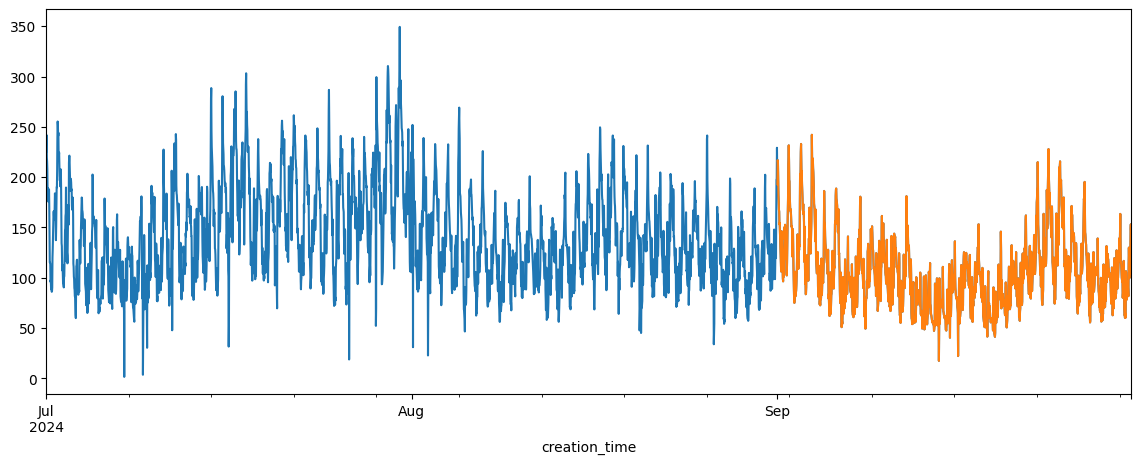

In [25]:
month = 9 # september
test_df = data_ingestion_training(month)
test_main_df = pre_process(test_df)
final_test_df = feature_engineering(test_main_df)
# final_df.set_index("creation_time",drop= True,inplace=True)
september_dataset = final_test_df.loc[final_test_df.index.month ==month]
september_dataset['KWh'].plot()
september_dataset

prediction with july fine tuned model


dataset_features shape: (1440, 18)
dataset_label shape: (1440,)
45/45 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 5.848610095977784
Root Mean Squared Error (RMSE): 7.619019360305995
R-squared: 0.956324672951588


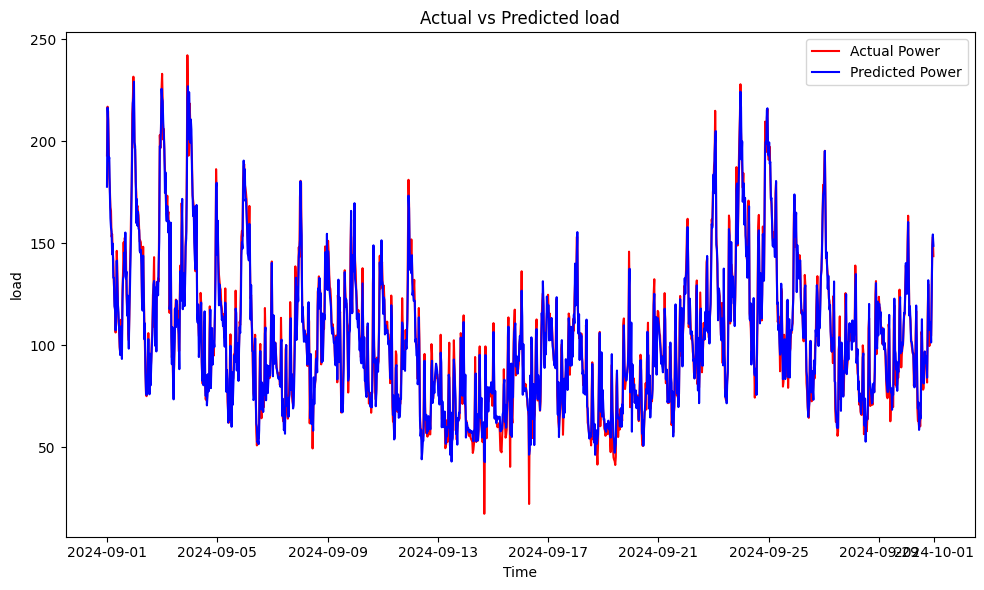

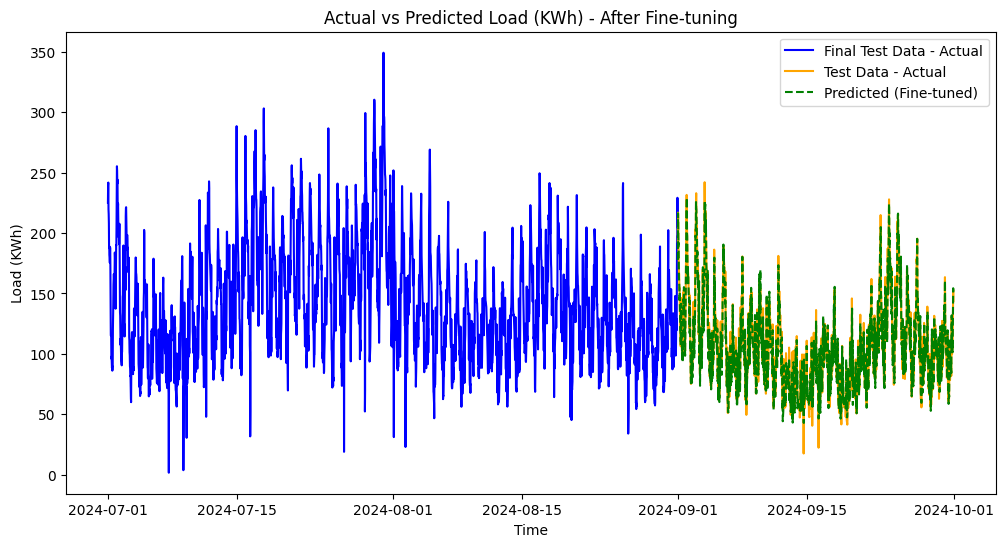

In [26]:
july_fine_tuned_model = load_model("models/fine_tuned_july_lstm_model")
dataset = september_dataset.copy()
predicted_september = prediction(dataset, july_fine_tuned_model)
last_two_month_data = pd.concat((july_dataset,august_dataset))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
# plt.plot(june_dataset.index, predicted_august, label="Predicted (june)", color="pink", linestyle="--")
plt.plot(dataset.index, predicted_september, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()

prediction with august fine tuned model


dataset_features shape: (1440, 18)
dataset_label shape: (1440,)
45/45 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 5.848610095977784
Root Mean Squared Error (RMSE): 7.619019360305995
R-squared: 0.956324672951588


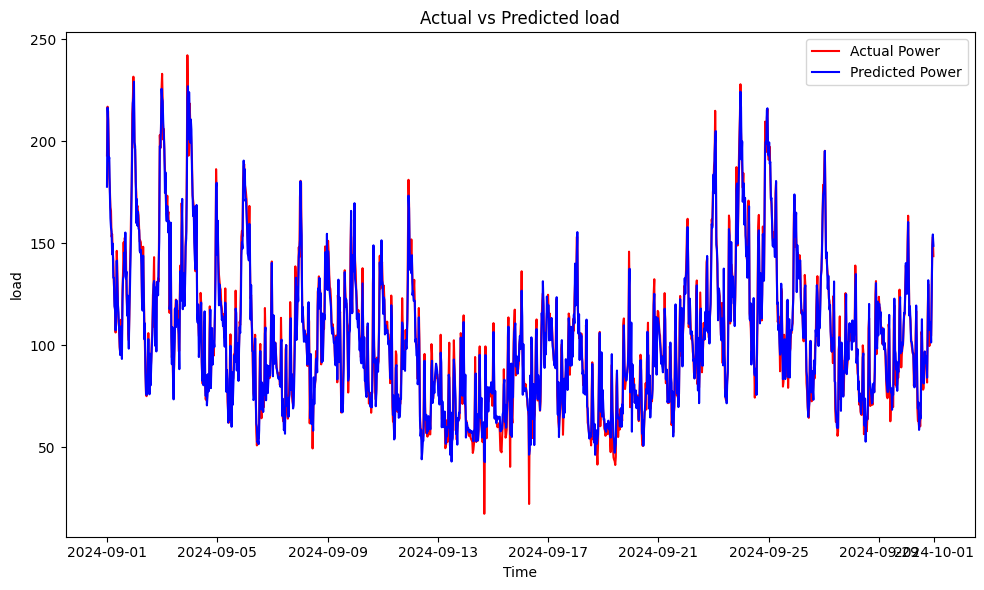

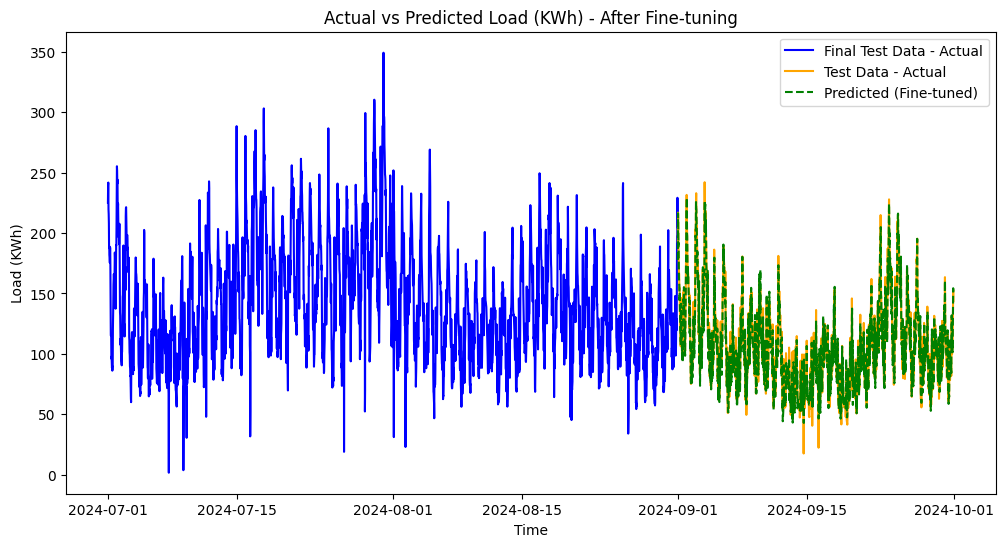

In [27]:
august_fine_tuned_model = load_model("models/fine_tuned_august_lstm_model")
dataset = september_dataset.copy()
predicted_september = prediction(dataset, august_fine_tuned_model)
last_two_month_data = pd.concat((july_dataset,august_dataset))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
# plt.plot(june_dataset.index, predicted_august, label="Predicted (june)", color="pink", linestyle="--")
plt.plot(dataset.index, predicted_september, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()

fine tunning with september data (august fine tuned model)


In [28]:
august_fine_tuned_model = load_model("models/fine_tuned_august_lstm_model")
# Separate features and labels
september_features, september_label = feature_label(september_dataset)
reshaped_september_features = reshape_fn(feature_scaler.transform(september_features))

# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fine-tune the model with May data
history = august_fine_tuned_model.fit(
    reshaped_september_features, september_label,
    epochs=100,  # You can adjust this depending on the performance
    batch_size=64,
    validation_split=0.1,  # Use 10% of May data for validation
    callbacks=[early_stopping]
)
save_model(august_fine_tuned_model, model_name="fine_tuned_september_lstm_model")


dataset_features shape: (1440, 18)
dataset_label shape: (1440,)
Epoch 1/100
21/21 [==============================] - 4s 37ms/step - loss: 144.7612 - val_loss: 58.4928
Epoch 2/100
21/21 [==============================] - 0s 10ms/step - loss: 141.9753 - val_loss: 56.1568
Epoch 3/100
21/21 [==============================] - 0s 10ms/step - loss: 141.9980 - val_loss: 54.6225
Epoch 4/100
21/21 [==============================] - 0s 10ms/step - loss: 143.7457 - val_loss: 62.8464
Epoch 5/100
21/21 [==============================] - 0s 10ms/step - loss: 138.0207 - val_loss: 54.7996
Epoch 6/100
21/21 [==============================] - 0s 10ms/step - loss: 143.9761 - val_loss: 53.6927
Epoch 7/100
21/21 [==============================] - 0s 11ms/step - loss: 138.3763 - val_loss: 53.7450
Epoch 8/100
21/21 [==============================] - 0s 10ms/step - loss: 148.0413 - val_loss: 58.1665
Epoch 9/100
21/21 [==============================] - 0s 10ms/step - loss: 138.2657 - val_loss: 53.9006
Epoch 10/

INFO:tensorflow:Assets written to: models\fine_tuned_september_lstm_model\assets


INFO:tensorflow:Assets written to: models\fine_tuned_september_lstm_model\assets


Model saved to: models\fine_tuned_september_lstm_model


dataset_features shape: (1440, 18)
dataset_label shape: (1440,)
45/45 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 5.557389506763882
Root Mean Squared Error (RMSE): 7.3509094056674265
R-squared: 0.95934442082716


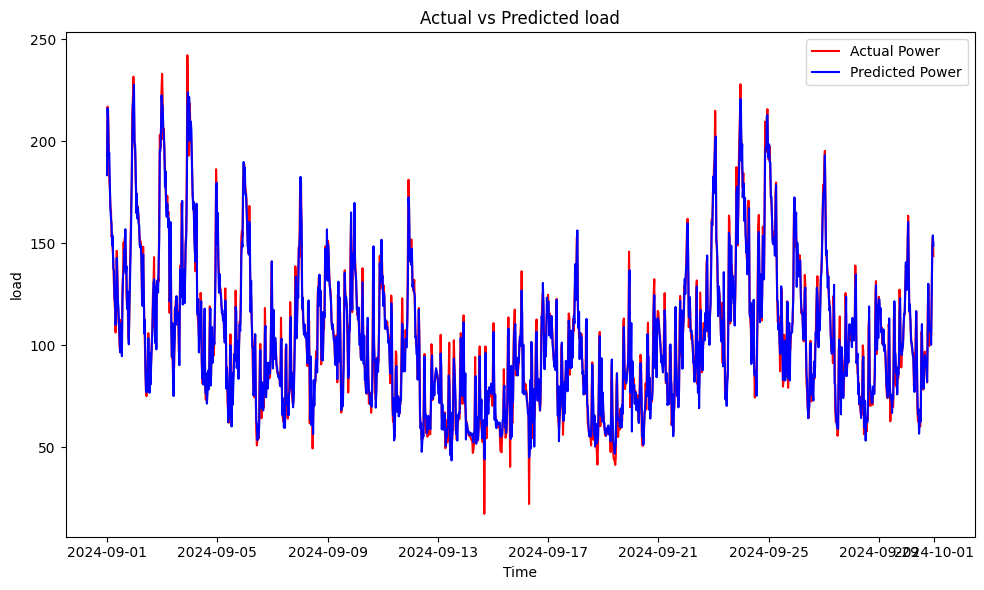

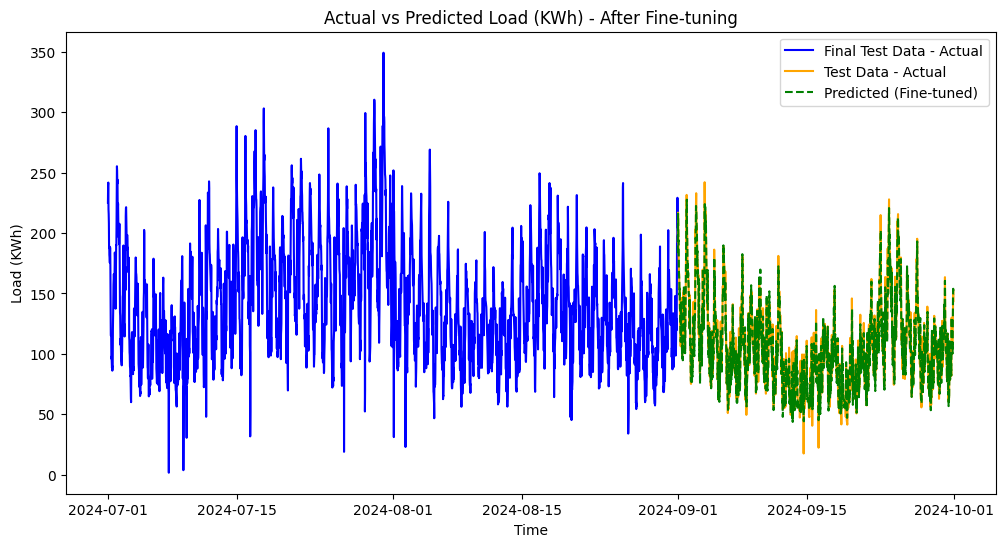

In [29]:
september_fine_tuned_model = load_model("models/fine_tuned_september_lstm_model")
dataset = september_dataset.copy()
predicted_september = prediction(dataset, september_fine_tuned_model)
last_two_month_data = pd.concat((july_dataset,august_dataset))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
# plt.plot(june_dataset.index, predicted_august, label="Predicted (june)", color="pink", linestyle="--")
plt.plot(dataset.index, predicted_september, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()

train with full data set

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 47
Duplicated index: 0
null_values : 0
df rows after basic checks: 31344
null vlaues after resampling: 48
null values after filling: 0


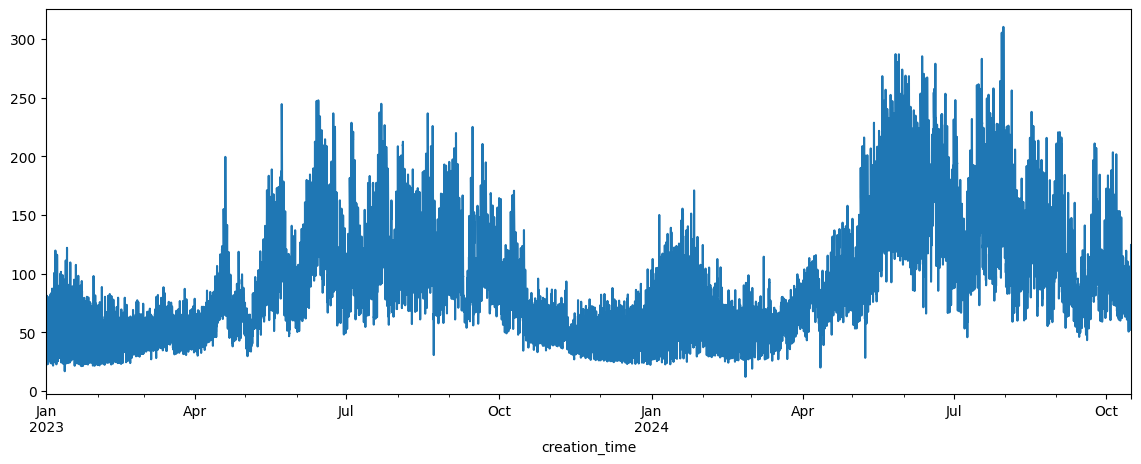

null vlaues after resampling: 3
null values after filling: 3
from_date:  2023-01-01 to_date:  2024-10-15
holidays_lst: [datetime.date(2023, 1, 1), datetime.date(2023, 1, 8), datetime.date(2023, 1, 14), datetime.date(2023, 1, 15), datetime.date(2023, 1, 22), datetime.date(2023, 1, 26), datetime.date(2023, 1, 29), datetime.date(2023, 2, 5), datetime.date(2023, 2, 12), datetime.date(2023, 2, 19), datetime.date(2023, 2, 26), datetime.date(2023, 3, 5), datetime.date(2023, 3, 8), datetime.date(2023, 3, 12), datetime.date(2023, 3, 19), datetime.date(2023, 3, 26), datetime.date(2023, 4, 2), datetime.date(2023, 4, 7), datetime.date(2023, 4, 9), datetime.date(2023, 4, 16), datetime.date(2023, 4, 21), datetime.date(2023, 4, 22), datetime.date(2023, 4, 23), datetime.date(2023, 4, 30), datetime.date(2023, 5, 1), datetime.date(2023, 5, 7), datetime.date(2023, 5, 14), datetime.date(2023, 5, 21), datetime.date(2023, 5, 28), datetime.date(2023, 6, 4), datetime.date(2023, 6, 11), datetime.date(2023, 6, 

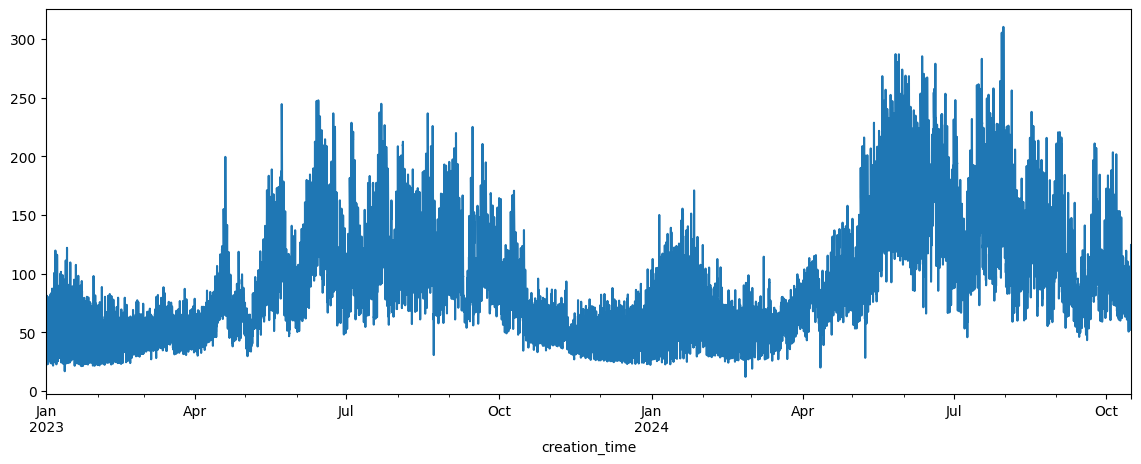

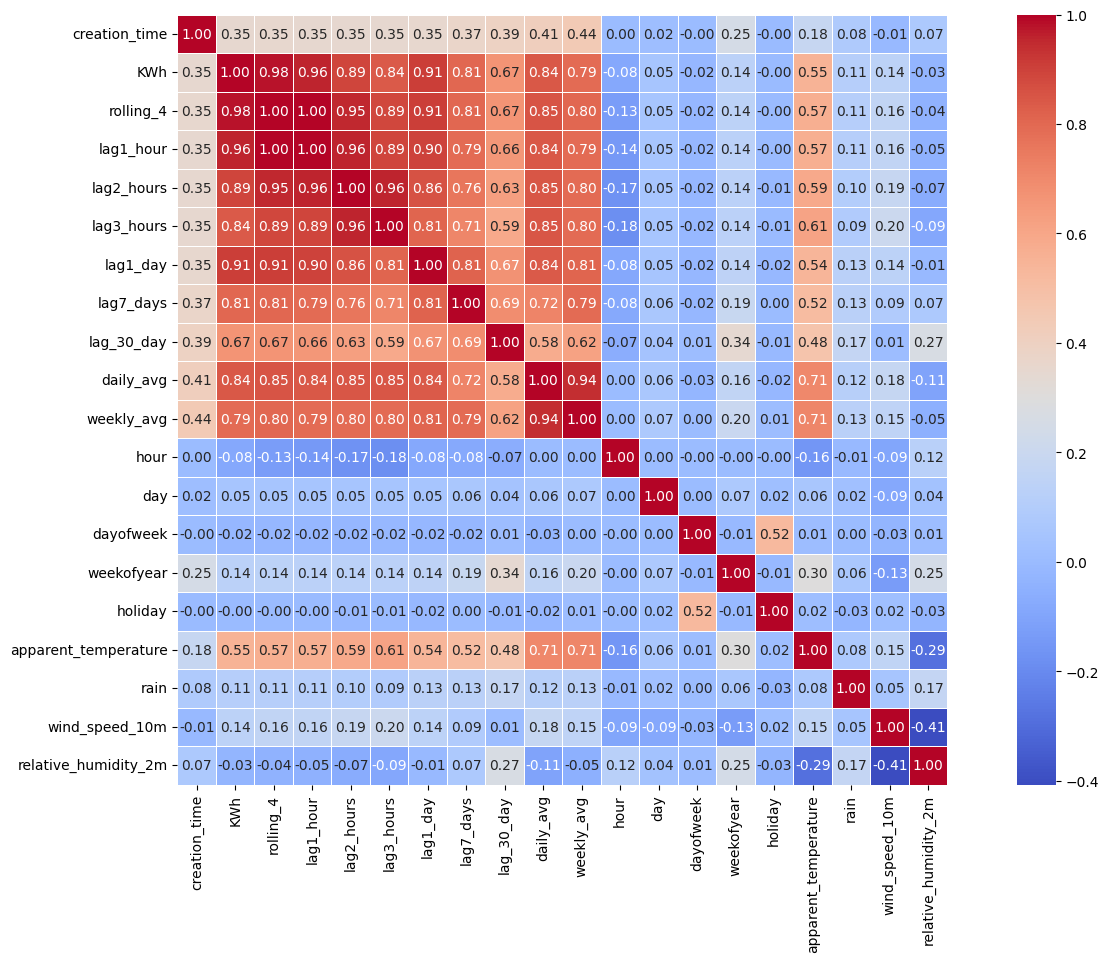

null values in final_df: 0
train_dataset_from_date:  2023-01-31 train_dataset_to_date:  2024-09-30
val_dataset_from_date:  2024-10-01 val_dataset_to_date:  2024-10-15


KWh  rolling_4  lag1_hour  lag2_hours  lag3_hours  \
creation_time                                                                
2023-01-31 01:30:00   38.125   48.61250     52.650      62.125      61.600   
2023-01-31 02:00:00   31.875   42.03125     45.475      58.200      62.225   
2023-01-31 02:30:00   25.875   35.33750     38.125      52.650      62.125   
2023-01-31 03:00:00   23.675   29.88750     31.875      45.475      58.200   
2023-01-31 03:30:00   22.700   26.03125     25.875      38.125      52.650   
...                      ...        ...        ...         ...         ...   
2024-10-15 21:30:00  105.600   89.66875     83.425      71.100      63.000   
2024-10-15 22:00:00  118.400  100.50000     94.575      75.075      68.050   
2024-10-15 22:30:00  124.725  110.82500    105.600      83.425      71.100   
2024-10-15 23:00:00  119.150  116.96875    118.400      94.575      75.075   
2024-10-15 23:30:00  116.150  119.60625    124.725     105.600      83.425   

                     lag1_day  lag7_days  lag_30_day  daily_avg  weekly_avg  \
creation_time                                                                 
2023-01-31 01:30:00    39.900     32.575      40.250  52.130208   49.703720   
2023-01-31 02:00:00    37.500     28.975      36.200  52.013021   49.712351   
2023-01-31 02:30:00    34.150     25.875      31.500  51.840625   49.712351   
2023-01-31 03:00:00    31.950     24.425      27.275  51.668229   49.710119   
2023-01-31 03:30:00    26.975     23.650      25.600  51.579167   49.707292   
...                       ...        ...         ...        ...         ...   
2024-10-15 21:30:00    86.600    106.450      88.400  78.327604   90.925446   
2024-10-15 22:00:00    84.800    110.350      89.125  79.027604   90.949405   
2024-10-15 22:30:00    90.150    120.800      89.250  79.747917   90.961086   
2024-10-15 23:00:00    96.575    139.425      92.250  80.218229   90.900744   
2024-10-15 23:30:00   101.425    148.850      95.750  80.525000   90.803423   

                     hour  day  dayofweek  weekofyear  holiday  \
creation_time                                                    
2023-01-31 01:30:00     1   31          1           5        0   
2023-01-31 02:00:00     2   31          1           5        0   
2023-01-31 02:30:00     2   31          1           5        0   
2023-01-31 03:00:00     3   31          1           5        0   
2023-01-31 03:30:00     3   31          1           5        0   
...                   ...  ...        ...         ...      ...   
2024-10-15 21:30:00    21   15          1          42        0   
2024-10-15 22:00:00    22   15          1          42        0   
2024-10-15 22:30:00    22   15          1          42        0   
2024-10-15 23:00:00    23   15          1          42        0   
2024-10-15 23:30:00    23   15          1          42        0   

                     apparent_temperature  rain  wind_speed_10m  \
creation_time                                                     
2023-01-31 01:30:00                  9.85   0.0           10.10   
2023-01-31 02:00:00                  9.80   0.0           10.90   
2023-01-31 02:30:00                 10.60   0.0           11.40   
2023-01-31 03:00:00                 11.40   0.0           11.90   
2023-01-31 03:30:00                 12.65   0.0           11.30   
...                                   ...   ...             ...   
2024-10-15 21:30:00                 20.80   0.0            6.80   
2024-10-15 22:00:00                 20.00   0.0            7.60   
2024-10-15 22:30:00                 20.35   0.0            6.85   
2024-10-15 23:00:00                 20.70   0.0            6.10   
2024-10-15 23:30:00                 20.10   0.0            6.35   

                     relative_humidity_2m  
creation_time                              
2023-01-31 01:30:00                  95.0  
2023-01-31 02:00:00                  95.0  
2023-01-31 02:30:00                  93.5  
2023-01-31 03:00:00            

In [42]:
def initial_data_ingestion():
    df_complete_data = pd.read_parquet('HT_meter_complete_data_9_id.parquet')
    df = df_complete_data[df_complete_data['sensor']=="6148740eea9db0.29702291"]  ## Jamia HT METER
    df = df.copy()

    df.drop("sensor", axis=1, inplace=True)
    print(f"df rows: {len(df)}")
    print(f"Duplicated rows: {df.duplicated().sum()}")
    df.set_index("creation_time", drop=True, inplace=True)
    df = df.loc[df.index.year>2022]
    # df = df.loc[~ ((df.index.year==2024) & (df.index.month>5))]

    print(f"Duplicated rows after datetime index: {df.duplicated().sum()}")
    df = df.drop_duplicates()
    df = df[df['R_Voltage'] != 0]
    # df = df.loc[~df['R_Voltage'] == 0]
    print(f"Duplicated index: {df.index.duplicated().sum()}")
    print(f"null_values : {df.isna().sum().sum()}")
    print(f"df rows after basic checks: {len(df)}")
    return df

def initial_validation(df):
    resample_df = df[['KWh']].resample(rule="30min").asfreq()
    print(f"null vlaues after resampling: {resample_df.isna().sum().sum()}")
    # resample_df[resample_df.isna().any(axis=1)]
    resample_df = resample_df.interpolate(method="linear")
    print(f"null values after filling: {resample_df.isna().sum().sum()}")
    resample_df['KWh'] = resample_df['KWh'].rolling(window=4).mean()
    resample_df['KWh'].plot()
    plt.show()
    return resample_df

def data_ingestion_training(month):
    df_complete_data = pd.read_parquet('HT_meter_complete_data_9_id.parquet')
    df = df_complete_data[df_complete_data['sensor']=="6148740eea9db0.29702291"]  ## Jamia HT METER
    df = df.copy()

    df.drop("sensor", axis=1, inplace=True)
    print(f"df rows: {len(df)}")
    print(f"Duplicated rows: {df.duplicated().sum()}")
    df.set_index("creation_time", drop=True, inplace=True)
    df = df.loc[df.index.year>2022]
    df = df.loc[((df.index.year==2024) & ((df.index.month>=(month-2)) & (df.index.month<(month+1))))]

    print(f"Duplicated rows after datetime index: {df.duplicated().sum()}")
    df = df.drop_duplicates()
    df = df[df['R_Voltage'] != 0]
    # df = df.loc[~df['R_Voltage'] == 0]
    print(f"Duplicated index: {df.index.duplicated().sum()}")
    print(f"null_values : {df.isna().sum().sum()}")
    print(f"df rows after basic checks: {len(df)}")
    return df

def pre_process(data):
    main_df = data[['KWh']].resample(rule="30min").asfreq()
    print(f"null vlaues after resampling: {main_df.isna().sum().sum()}")
    # resample_df[resample_df.isna().any(axis=1)]
    main_df = main_df.interpolate(method="linear")
    print(f"null values after filling: {main_df.isna().sum().sum()}")
    # resample_df['KWh'] = resample_df['KWh'].rolling(window=4).mean()
    main_df['KWh'].plot()
    # plt.show()
    return main_df

df = initial_data_ingestion()
resample_df = initial_validation(df)
final_df = feature_engineering(pre_process(resample_df),c_matrix=True)

train_dataset = final_df.loc[~((final_df.index.month==10)& (final_df.index.year == 2024))]
from_date = train_dataset.first_valid_index().date()
to_date = train_dataset.last_valid_index().date()
print("train_dataset_from_date: ",from_date,"train_dataset_to_date: ",to_date)
val_dataset = final_df.loc[(final_df.index.month==10)& (final_df.index.year == 2024)]
from_date = val_dataset.first_valid_index().date()
to_date = val_dataset.last_valid_index().date()
print("val_dataset_from_date: ",from_date,"val_dataset_to_date: ",to_date)
final_df



dataset_features shape: (48, 18)
dataset_label shape: (48,)
2/2 [==============================] - 1s 6ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 2.647850545247397
Root Mean Squared Error (RMSE): 3.06143551304446
R-squared: 0.9875033222268159


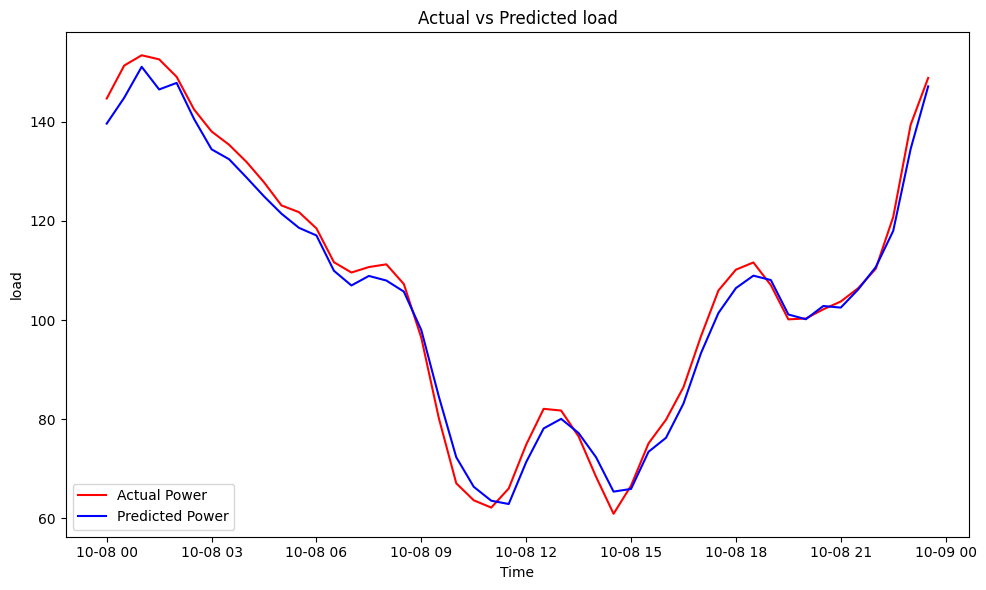

ValueError: x and y must have same first dimension, but have shapes (720,) and (48, 1)

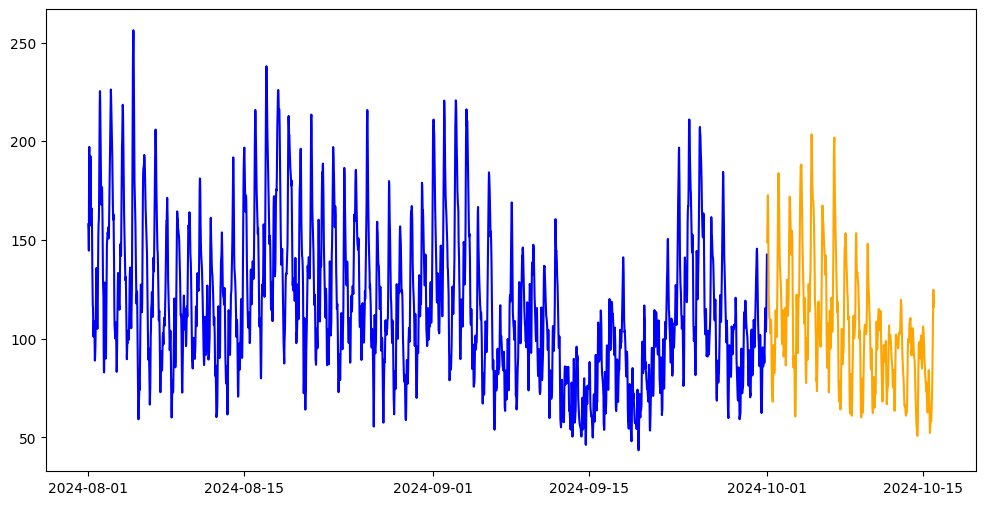

In [43]:
september_fine_tuned_model = load_model("models/fine_tuned_september_lstm_model")
dataset = val_dataset.copy()
predicted_september = prediction(day_wise_prediction(dataset,8), september_fine_tuned_model)
last_two_month_data = final_df.loc[(final_df.index.month.isin([8,9])) & (final_df.index.year == 2024)]#pd.concat((july_dataset,august_dataset))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
# plt.plot(june_dataset.index, predicted_august, label="Predicted (june)", color="pink", linestyle="--")
plt.plot(dataset.index, predicted_september, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()

In [44]:
# lstm_model = model_training(train_dataset,val_dataset,model="DL")


# def load_scalar():
# # with open('models/Min_Max_Scaler.pkl', 'rb') as f:
# with open("models/minmax_scaler_with_rolling.pkl", 'rb') as f:
#     feature_scaler = pickle.load(f)
# return feature_scaler


train_features,train_label = feature_label(train_dataset)
val_features, val_label = feature_label(val_dataset)
f_scaler = MinMaxScaler()
# f_scaler.fit_transform(train_features)    

col = train_features.columns
train_features[col] = f_scaler.fit_transform(train_features)
train_features


reshaped_train_features= reshape_fn(train_features)
reshaped_val_features = reshape_fn(f_scaler.transform(val_features))
print(reshaped_train_features.shape)
print(reshaped_val_features.shape)


# Build LSTM model with increased dropout and L2 regularization
lstm_model = Sequential([            
    # Adding LSTM layers with increased dropout
    LSTM(units=64, return_sequences=True, input_shape=(reshaped_train_features.shape[1], reshaped_train_features.shape[2])),
    Dropout(0.3),  # Increased dropout
    LSTM(units=64, return_sequences=False),
    Dropout(0.3),  # Increased dropout
    # Adding dense output layer with L2 regularization
    Dense(units=1, kernel_regularizer=l2(0.01))  # L2 regularization
])
# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error'
)
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Train the model with early stopping
history = lstm_model.fit(reshaped_train_features, train_label, epochs=500, batch_size=64, 
                        validation_data=(reshaped_val_features, val_label), 
                        callbacks=[early_stopping])
lstm_model





dataset_features shape: (29229, 18)
dataset_label shape: (29229,)
dataset_features shape: (720, 18)
dataset_label shape: (720,)
(29229, 1, 18)
(720, 1, 18)
Epoch 1/500
457/457 [==============================] - 15s 23ms/step - loss: 8076.0483 - val_loss: 6079.1450
Epoch 2/500
457/457 [==============================] - 9s 20ms/step - loss: 5083.1138 - val_loss: 3730.8091
Epoch 3/500
457/457 [==============================] - 9s 20ms/step - loss: 3650.2498 - val_loss: 2376.1221
Epoch 4/500
457/457 [==============================] - 10s 21ms/step - loss: 2712.7480 - val_loss: 1499.3446
Epoch 5/500
457/457 [==============================] - 9s 20ms/step - loss: 1958.6227 - val_loss: 952.6756
Epoch 6/500
457/457 [==============================] - 10s 21ms/step - loss: 1458.5192 - val_loss: 599.7420
Epoch 7/500
457/457 [==============================] - 9s 20ms/step - loss: 1105.6843 - val_loss: 391.4575
Epoch 8/500
457/457 [==============================] - 9s 20ms/step - loss: 847.6033 - v

dataset_features shape: (720, 18)
dataset_label shape: (720,)


23/23 [==============================] - 1s 2ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 20.467022243075903
Root Mean Squared Error (RMSE): 22.067813516879482
R-squared: 0.4642676286914249


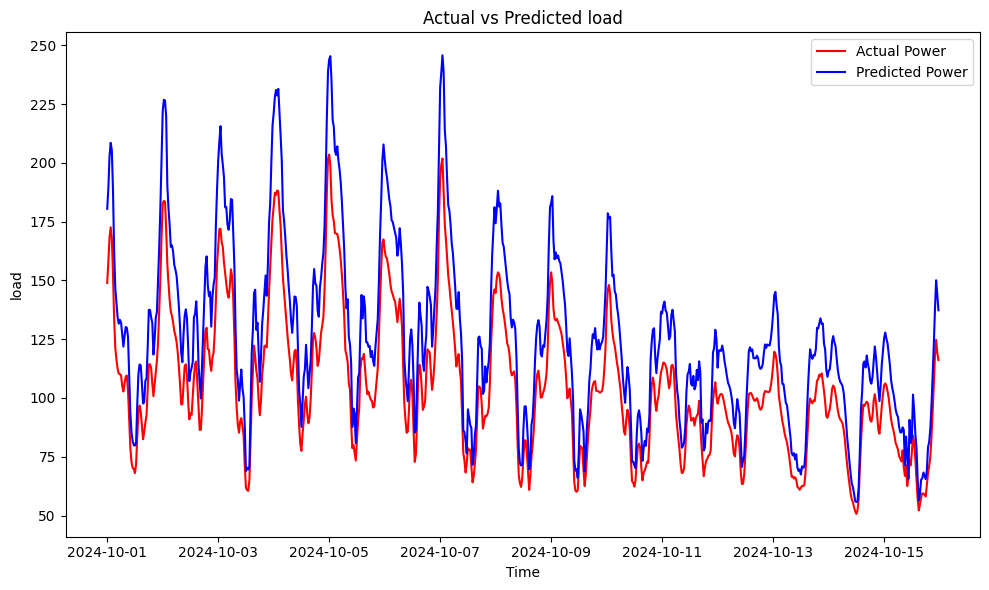

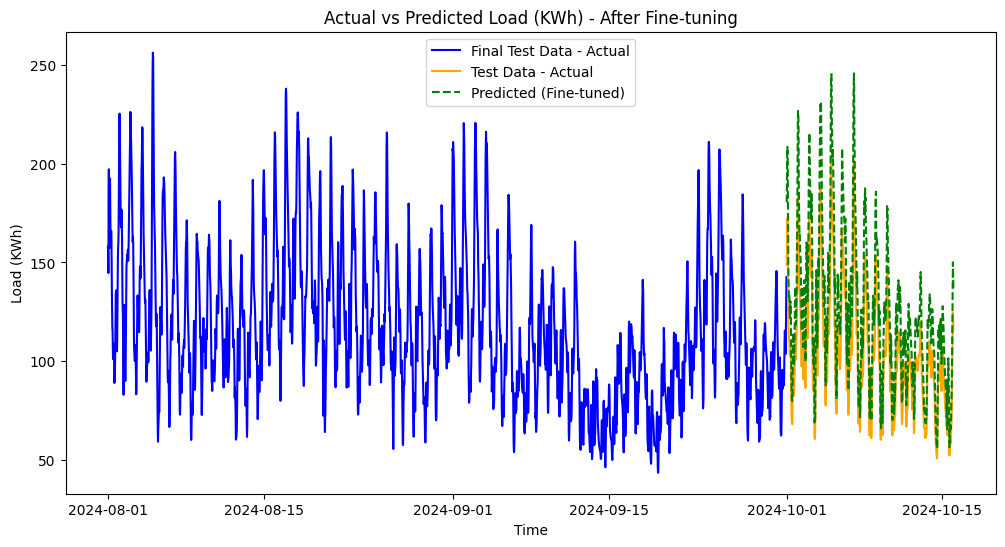

In [45]:
# september_fine_tuned_model = load_model("models/fine_tuned_september_lstm_model")
dataset = val_dataset.copy()
# predicted_september = prediction(day_wise_prediction(dataset,8), lstm_model)
predicted_september = prediction(dataset, lstm_model)
last_two_month_data = final_df.loc[(final_df.index.month.isin([8,9])) & (final_df.index.year == 2024)]#pd.concat((july_dataset,august_dataset))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_two_month_data['KWh'], label="Final Test Data - Actual", color="blue")
plt.plot(dataset['KWh'], label="Test Data - Actual", color="orange")
# plt.plot(june_dataset.index, predicted_august, label="Predicted (june)", color="pink", linestyle="--")
plt.plot(dataset.index, predicted_september, label="Predicted (Fine-tuned)", color="green", linestyle="--")
plt.title("Actual vs Predicted Load (KWh) - After Fine-tuning")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
plt.legend()
plt.show()

In [46]:
final_df.describe()

KWh     rolling_4     lag1_hour    lag2_hours    lag3_hours  \
count  29949.000000  29949.000000  29949.000000  29949.000000  29949.000000   
mean      94.615592     94.612156     94.611011     94.606911     94.604362   
std       49.097895     48.529384     49.098953     49.099261     49.099947   
min       12.162500     22.087500     12.162500     12.162500     12.162500   
25%       56.050000     56.118750     56.050000     56.050000     56.050000   
50%       84.425000     84.687500     84.425000     84.425000     84.400000   
75%      121.675000    121.612500    121.675000    121.675000    121.675000   
max      310.400000    305.587500    310.400000    310.400000    310.400000   

           lag1_day     lag7_days    lag_30_day     daily_avg    weekly_avg  \
count  29949.000000  29949.000000  29949.000000  29949.000000  29949.000000   
mean      94.570142     94.154306     92.361742     94.598480     94.414498   
std       49.123390     49.311189     49.438051     41.718312     40.251177   
min       12.162500     12.162500     12.162500     39.285417     42.735417   
25%       55.975000     55.350000     54.000000     53.851042     54.166146   
50%       84.375000     83.575000     80.425000     90.144792     92.072842   
75%      121.675000    121.500000    119.325000    124.102083    121.495387   
max      310.400000    310.400000    310.400000    224.897396    190.313542   

               hour           day     dayofweek  weekofyear       holiday  \
count  29949.000000  29949.000000  29949.000000     29949.0  29949.000000   
mean      11.501119     15.548132      2.996995   25.133427      0.177902   
std        6.921745      8.801952      2.000031   13.488424      0.382437   
min        0.000000      1.000000      0.000000         1.0      0.000000   
25%        6.000000      8.000000      1.000000        14.0      0.000000   
50%       12.000000     15.000000      3.000000        25.0      0.000000   
75%       18.000000     23.000000      5.000000        36.0      0.000000   
max       23.000000     31.000000      6.000000        52.0      1.000000   

       apparent_temperature          rain  wind_speed_10m  \
count          29949.000000  29949.000000    29949.000000   
mean              26.957150      0.137240        9.083487   
std                9.488138      0.831872        4.623169   
min                0.200000      0.000000        0.000000   
25%               19.850000      0.000000        6.050000   
50%               29.300000      0.000000        8.200000   
75%               34.400000      0.000000       11.200000   
max               46.300000     30.600000       36.300000   

       relative_humidity_2m  
count          29949.000000  
mean              62.863000  
std               24.840699  
min                4.000000  
25%               43.000000  
50%               67.000000  
75%               84.500000  
max              100.000000